In [33]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [34]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [35]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


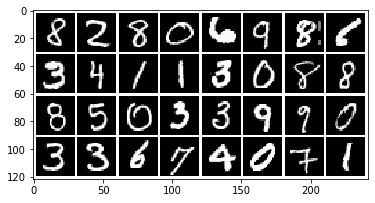

torch.Size([32, 1, 28, 28])


In [36]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [37]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

In [38]:
# Define Gen and Disc loss
def gen_loss(disc_gen):
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [39]:
### Create new models ###

z_size = 128

gen = models.FCNet(imsize=(1, 1, z_size), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(1, 28, 28), s=64)

Version 0.4


In [40]:
# Set training parameters

g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)

In [41]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)

z = torch.randn(sample.shape[0], 1, z_size).to(device)
gen_out = gen(z)

disc_output_real = disc(sample)
disc_output_generated = disc(gen_out)

g_loss = gen_loss(disc_output_generated)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 0.7424723505973816
Discriminator initial loss: 0.6859889030456543


In [42]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            # stack magnitudes to noise / generator input
            z = torch.randn(sample.shape[0], 1, z_size).to(device)
            
            # calc gen output
            gen.train()
            gen_output = gen(z)
            
            # calc disc output for real and generated image
            disc.train()
            disc_output_real = disc(x)
            disc_output_generated = disc(gen_output)
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_value_(gen.parameters(), 1e-1)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            #torch.nn.utils.clip_grad_value_(disc.parameters(), 1e-1)
            d_opt.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.legend()
        plt.show()
        
    return None

In [50]:
model_name = "gan784"

epoch:  1 	 step:0 	 loss: 0.7369
epoch:  1 	 step:100 	 loss: 5.295
epoch:  1 	 step:200 	 loss: 5.995
epoch:  1 	 step:300 	 loss: 6.131
epoch:  1 	 step:400 	 loss: 7.071
epoch:  1 	 step:500 	 loss: 7.959
epoch:  1 	 step:600 	 loss: 7.518
epoch:  1 	 step:700 	 loss: 8.152
epoch:  1 	 step:800 	 loss: 7.746
epoch:  1 	 step:900 	 loss: 7.833
epoch:  1 	 step:1000 	 loss: 6.128
epoch:  1 	 step:1100 	 loss: 6.312
epoch:  1 	 step:1200 	 loss: 6.861
epoch:  1 	 step:1300 	 loss: 4.986
epoch:  1 	 step:1400 	 loss: 5.383
epoch:  1 	 step:1500 	 loss: 7.052
epoch:  1 	 step:1600 	 loss: 5.444
epoch:  1 	 step:1700 	 loss: 6.466
epoch:  1 	 step:1800 	 loss: 3.823


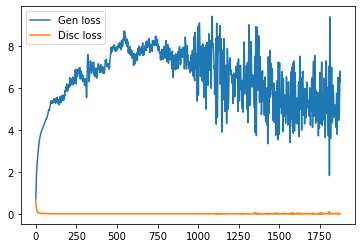

epoch:  2 	 step:0 	 loss: 5.905
epoch:  2 	 step:100 	 loss: 5.39
epoch:  2 	 step:200 	 loss: 4.111
epoch:  2 	 step:300 	 loss: 5.498
epoch:  2 	 step:400 	 loss: 5.661
epoch:  2 	 step:500 	 loss: 4.678
epoch:  2 	 step:600 	 loss: 6.218
epoch:  2 	 step:700 	 loss: 6.041
epoch:  2 	 step:800 	 loss: 5.768
epoch:  2 	 step:900 	 loss: 7.222
epoch:  2 	 step:1000 	 loss: 4.438
epoch:  2 	 step:1100 	 loss: 4.246
epoch:  2 	 step:1200 	 loss: 4.626
epoch:  2 	 step:1300 	 loss: 4.411
epoch:  2 	 step:1400 	 loss: 4.463
epoch:  2 	 step:1500 	 loss: 5.23
epoch:  2 	 step:1600 	 loss: 6.865
epoch:  2 	 step:1700 	 loss: 5.861
epoch:  2 	 step:1800 	 loss: 4.552


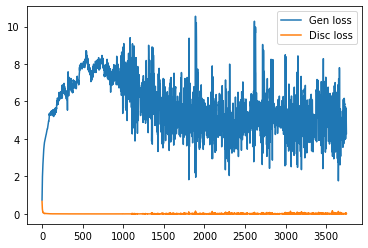

epoch:  3 	 step:0 	 loss: 4.424
epoch:  3 	 step:100 	 loss: 4.536
epoch:  3 	 step:200 	 loss: 4.446
epoch:  3 	 step:300 	 loss: 5.433
epoch:  3 	 step:400 	 loss: 5.579
epoch:  3 	 step:500 	 loss: 4.147
epoch:  3 	 step:600 	 loss: 4.878
epoch:  3 	 step:700 	 loss: 2.04
epoch:  3 	 step:800 	 loss: 4.76
epoch:  3 	 step:900 	 loss: 3.877
epoch:  3 	 step:1000 	 loss: 5.436
epoch:  3 	 step:1100 	 loss: 4.618
epoch:  3 	 step:1200 	 loss: 4.36
epoch:  3 	 step:1300 	 loss: 5.073
epoch:  3 	 step:1400 	 loss: 3.425
epoch:  3 	 step:1500 	 loss: 4.07
epoch:  3 	 step:1600 	 loss: 4.064
epoch:  3 	 step:1700 	 loss: 5.264
epoch:  3 	 step:1800 	 loss: 6.473


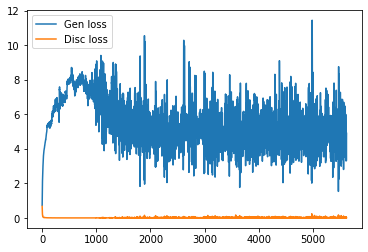

epoch:  4 	 step:0 	 loss: 5.447
epoch:  4 	 step:100 	 loss: 4.017
epoch:  4 	 step:200 	 loss: 5.551
epoch:  4 	 step:300 	 loss: 3.712
epoch:  4 	 step:400 	 loss: 4.005
epoch:  4 	 step:500 	 loss: 5.77
epoch:  4 	 step:600 	 loss: 3.811
epoch:  4 	 step:700 	 loss: 5.855
epoch:  4 	 step:800 	 loss: 6.936
epoch:  4 	 step:900 	 loss: 6.54
epoch:  4 	 step:1000 	 loss: 4.597
epoch:  4 	 step:1100 	 loss: 5.579
epoch:  4 	 step:1200 	 loss: 6.708
epoch:  4 	 step:1300 	 loss: 4.002
epoch:  4 	 step:1400 	 loss: 4.837
epoch:  4 	 step:1500 	 loss: 4.469
epoch:  4 	 step:1600 	 loss: 6.14
epoch:  4 	 step:1700 	 loss: 5.698
epoch:  4 	 step:1800 	 loss: 6.227


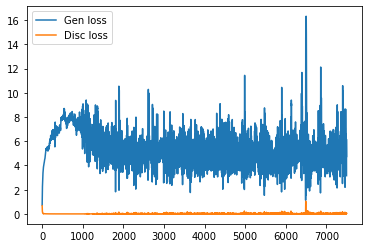

epoch:  5 	 step:0 	 loss: 3.243
epoch:  5 	 step:100 	 loss: 3.287
epoch:  5 	 step:200 	 loss: 8.767
epoch:  5 	 step:300 	 loss: 5.058
epoch:  5 	 step:400 	 loss: 4.788
epoch:  5 	 step:500 	 loss: 5.35
epoch:  5 	 step:600 	 loss: 5.691
epoch:  5 	 step:700 	 loss: 5.283
epoch:  5 	 step:800 	 loss: 4.847
epoch:  5 	 step:900 	 loss: 5.694
epoch:  5 	 step:1000 	 loss: 5.637
epoch:  5 	 step:1100 	 loss: 4.83
epoch:  5 	 step:1200 	 loss: 8.026
epoch:  5 	 step:1300 	 loss: 4.768
epoch:  5 	 step:1400 	 loss: 5.547
epoch:  5 	 step:1500 	 loss: 4.066
epoch:  5 	 step:1600 	 loss: 11.09
epoch:  5 	 step:1700 	 loss: 4.904
epoch:  5 	 step:1800 	 loss: 6.596


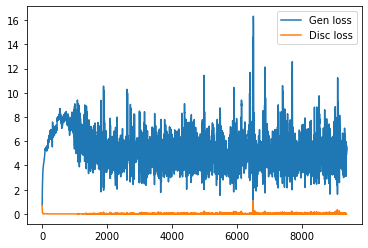

epoch:  6 	 step:0 	 loss: 6.028
epoch:  6 	 step:100 	 loss: 4.447
epoch:  6 	 step:200 	 loss: 3.259
epoch:  6 	 step:300 	 loss: 5.819
epoch:  6 	 step:400 	 loss: 2.944
epoch:  6 	 step:500 	 loss: 5.549
epoch:  6 	 step:600 	 loss: 6.329
epoch:  6 	 step:700 	 loss: 5.949
epoch:  6 	 step:800 	 loss: 3.722
epoch:  6 	 step:900 	 loss: 3.641
epoch:  6 	 step:1000 	 loss: 4.452
epoch:  6 	 step:1100 	 loss: 3.766
epoch:  6 	 step:1200 	 loss: 4.92
epoch:  6 	 step:1300 	 loss: 4.403
epoch:  6 	 step:1400 	 loss: 6.383
epoch:  6 	 step:1500 	 loss: 3.136
epoch:  6 	 step:1600 	 loss: 6.296
epoch:  6 	 step:1700 	 loss: 3.317
epoch:  6 	 step:1800 	 loss: 4.202


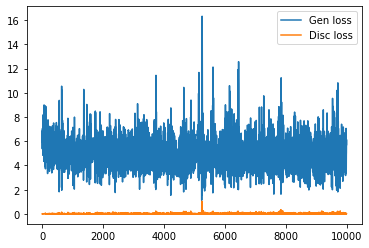

epoch:  7 	 step:0 	 loss: 6.755
epoch:  7 	 step:100 	 loss: 2.833
epoch:  7 	 step:200 	 loss: 4.43
epoch:  7 	 step:300 	 loss: 5.12
epoch:  7 	 step:400 	 loss: 6.874
epoch:  7 	 step:500 	 loss: 5.455
epoch:  7 	 step:600 	 loss: 5.966
epoch:  7 	 step:700 	 loss: 5.515
epoch:  7 	 step:800 	 loss: 5.94
epoch:  7 	 step:900 	 loss: 8.082
epoch:  7 	 step:1000 	 loss: 6.429
epoch:  7 	 step:1100 	 loss: 4.517
epoch:  7 	 step:1200 	 loss: 5.522
epoch:  7 	 step:1300 	 loss: 4.532
epoch:  7 	 step:1400 	 loss: 4.426
epoch:  7 	 step:1500 	 loss: 6.417
epoch:  7 	 step:1600 	 loss: 4.429
epoch:  7 	 step:1700 	 loss: 5.477
epoch:  7 	 step:1800 	 loss: 3.904


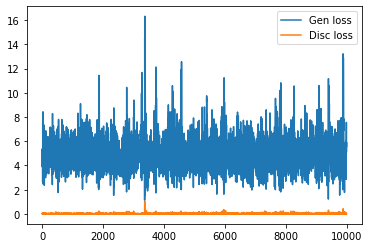

epoch:  8 	 step:0 	 loss: 5.478
epoch:  8 	 step:100 	 loss: 6.361
epoch:  8 	 step:200 	 loss: 4.558
epoch:  8 	 step:300 	 loss: 4.508
epoch:  8 	 step:400 	 loss: 4.66
epoch:  8 	 step:500 	 loss: 5.85
epoch:  8 	 step:600 	 loss: 5.321
epoch:  8 	 step:700 	 loss: 4.96
epoch:  8 	 step:800 	 loss: 5.337
epoch:  8 	 step:900 	 loss: 3.722
epoch:  8 	 step:1000 	 loss: 4.583
epoch:  8 	 step:1100 	 loss: 6.381
epoch:  8 	 step:1200 	 loss: 5.181
epoch:  8 	 step:1300 	 loss: 4.758
epoch:  8 	 step:1400 	 loss: 4.905
epoch:  8 	 step:1500 	 loss: 5.962
epoch:  8 	 step:1600 	 loss: 4.059
epoch:  8 	 step:1700 	 loss: 4.167
epoch:  8 	 step:1800 	 loss: 6.454


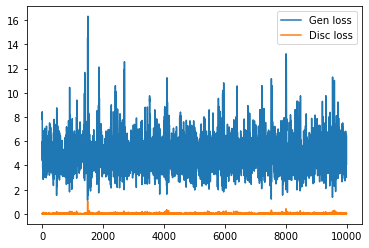

epoch:  9 	 step:0 	 loss: 4.43
epoch:  9 	 step:100 	 loss: 11.37
epoch:  9 	 step:200 	 loss: 6.695
epoch:  9 	 step:300 	 loss: 5.722
epoch:  9 	 step:400 	 loss: 4.829
epoch:  9 	 step:500 	 loss: 4.177
epoch:  9 	 step:600 	 loss: 6.634
epoch:  9 	 step:700 	 loss: 3.638
epoch:  9 	 step:800 	 loss: 4.863
epoch:  9 	 step:900 	 loss: 4.46
epoch:  9 	 step:1000 	 loss: 7.237
epoch:  9 	 step:1100 	 loss: 5.218
epoch:  9 	 step:1200 	 loss: 6.026
epoch:  9 	 step:1300 	 loss: 4.726
epoch:  9 	 step:1400 	 loss: 5.776
epoch:  9 	 step:1500 	 loss: 3.171
epoch:  9 	 step:1600 	 loss: 4.11
epoch:  9 	 step:1700 	 loss: 6.305
epoch:  9 	 step:1800 	 loss: 7.163


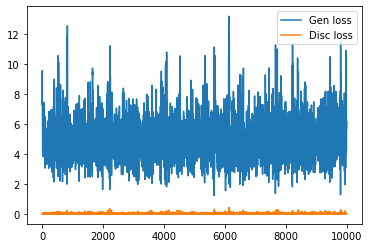

epoch: 10 	 step:0 	 loss: 4.988
epoch: 10 	 step:100 	 loss: 4.863
epoch: 10 	 step:200 	 loss: 7.391
epoch: 10 	 step:300 	 loss: 4.718
epoch: 10 	 step:400 	 loss: 5.01
epoch: 10 	 step:500 	 loss: 4.303
epoch: 10 	 step:600 	 loss: 6.215
epoch: 10 	 step:700 	 loss: 5.941
epoch: 10 	 step:800 	 loss: 3.587
epoch: 10 	 step:900 	 loss: 3.866
epoch: 10 	 step:1000 	 loss: 5.221
epoch: 10 	 step:1100 	 loss: 5.002
epoch: 10 	 step:1200 	 loss: 6.195
epoch: 10 	 step:1300 	 loss: 6.692
epoch: 10 	 step:1400 	 loss: 3.935
epoch: 10 	 step:1500 	 loss: 5.462
epoch: 10 	 step:1600 	 loss: 6.736
epoch: 10 	 step:1700 	 loss: 4.899
epoch: 10 	 step:1800 	 loss: 6.536


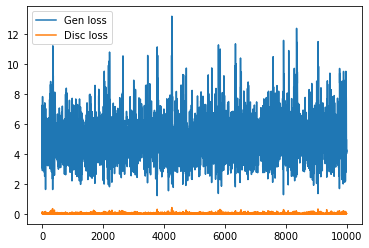

epoch: 11 	 step:0 	 loss: 4.697
epoch: 11 	 step:100 	 loss: 3.238
epoch: 11 	 step:200 	 loss: 3.871
epoch: 11 	 step:300 	 loss: 3.289
epoch: 11 	 step:400 	 loss: 4.865
epoch: 11 	 step:500 	 loss: 5.461
epoch: 11 	 step:600 	 loss: 6.556
epoch: 11 	 step:700 	 loss: 4.928
epoch: 11 	 step:800 	 loss: 4.644
epoch: 11 	 step:900 	 loss: 4.412
epoch: 11 	 step:1000 	 loss: 2.988
epoch: 11 	 step:1100 	 loss: 2.554
epoch: 11 	 step:1200 	 loss: 4.79
epoch: 11 	 step:1300 	 loss: 5.585
epoch: 11 	 step:1400 	 loss: 6.306
epoch: 11 	 step:1500 	 loss: 4.862
epoch: 11 	 step:1600 	 loss: 4.837
epoch: 11 	 step:1700 	 loss: 4.889
epoch: 11 	 step:1800 	 loss: 5.0


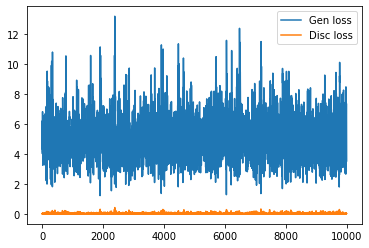

epoch: 12 	 step:0 	 loss: 6.134
epoch: 12 	 step:100 	 loss: 5.302
epoch: 12 	 step:200 	 loss: 5.49
epoch: 12 	 step:300 	 loss: 5.482
epoch: 12 	 step:400 	 loss: 4.868
epoch: 12 	 step:500 	 loss: 4.132
epoch: 12 	 step:600 	 loss: 4.136
epoch: 12 	 step:700 	 loss: 4.536
epoch: 12 	 step:800 	 loss: 6.518
epoch: 12 	 step:900 	 loss: 5.387
epoch: 12 	 step:1000 	 loss: 4.19
epoch: 12 	 step:1100 	 loss: 7.712
epoch: 12 	 step:1200 	 loss: 6.574
epoch: 12 	 step:1300 	 loss: 4.416
epoch: 12 	 step:1400 	 loss: 4.882
epoch: 12 	 step:1500 	 loss: 4.345
epoch: 12 	 step:1600 	 loss: 5.195
epoch: 12 	 step:1700 	 loss: 4.014
epoch: 12 	 step:1800 	 loss: 4.918


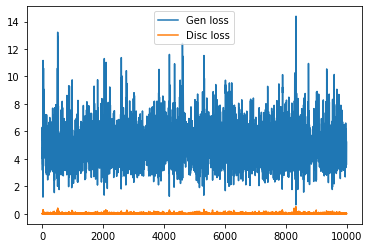

epoch: 13 	 step:0 	 loss: 5.286
epoch: 13 	 step:100 	 loss: 6.209
epoch: 13 	 step:200 	 loss: 6.416
epoch: 13 	 step:300 	 loss: 4.703
epoch: 13 	 step:400 	 loss: 5.547
epoch: 13 	 step:500 	 loss: 5.84
epoch: 13 	 step:600 	 loss: 4.751
epoch: 13 	 step:700 	 loss: 4.884
epoch: 13 	 step:800 	 loss: 8.21
epoch: 13 	 step:900 	 loss: 5.89
epoch: 13 	 step:1000 	 loss: 5.001
epoch: 13 	 step:1100 	 loss: 6.286
epoch: 13 	 step:1200 	 loss: 5.795
epoch: 13 	 step:1300 	 loss: 6.206
epoch: 13 	 step:1400 	 loss: 7.516
epoch: 13 	 step:1500 	 loss: 6.851
epoch: 13 	 step:1600 	 loss: 7.027
epoch: 13 	 step:1700 	 loss: 7.405
epoch: 13 	 step:1800 	 loss: 5.095


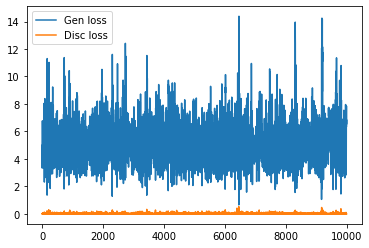

epoch: 14 	 step:0 	 loss: 6.577
epoch: 14 	 step:100 	 loss: 4.881
epoch: 14 	 step:200 	 loss: 5.918
epoch: 14 	 step:300 	 loss: 4.798
epoch: 14 	 step:400 	 loss: 4.922
epoch: 14 	 step:500 	 loss: 6.021
epoch: 14 	 step:600 	 loss: 8.079
epoch: 14 	 step:700 	 loss: 5.655
epoch: 14 	 step:800 	 loss: 7.635
epoch: 14 	 step:900 	 loss: 4.878
epoch: 14 	 step:1000 	 loss: 4.288
epoch: 14 	 step:1100 	 loss: 4.318
epoch: 14 	 step:1200 	 loss: 5.143
epoch: 14 	 step:1300 	 loss: 4.306
epoch: 14 	 step:1400 	 loss: 7.703
epoch: 14 	 step:1500 	 loss: 4.496
epoch: 14 	 step:1600 	 loss: 5.095
epoch: 14 	 step:1700 	 loss: 4.92
epoch: 14 	 step:1800 	 loss: 3.143


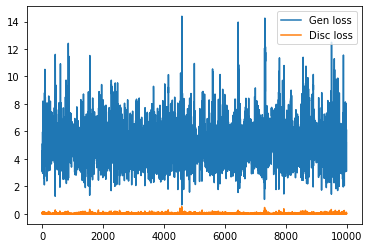

epoch: 15 	 step:0 	 loss: 4.579
epoch: 15 	 step:100 	 loss: 6.874
epoch: 15 	 step:200 	 loss: 3.092
epoch: 15 	 step:300 	 loss: 5.456
epoch: 15 	 step:400 	 loss: 6.456
epoch: 15 	 step:500 	 loss: 5.287
epoch: 15 	 step:600 	 loss: 4.175
epoch: 15 	 step:700 	 loss: 6.185
epoch: 15 	 step:800 	 loss: 10.69
epoch: 15 	 step:900 	 loss: 4.115
epoch: 15 	 step:1000 	 loss: 6.265
epoch: 15 	 step:1100 	 loss: 5.176
epoch: 15 	 step:1200 	 loss: 7.524
epoch: 15 	 step:1300 	 loss: 5.045
epoch: 15 	 step:1400 	 loss: 6.362
epoch: 15 	 step:1500 	 loss: 3.469
epoch: 15 	 step:1600 	 loss: 4.943
epoch: 15 	 step:1700 	 loss: 5.441
epoch: 15 	 step:1800 	 loss: 3.037


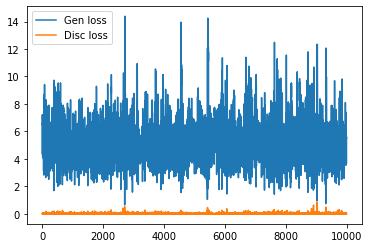

epoch: 16 	 step:0 	 loss: 4.484
epoch: 16 	 step:100 	 loss: 5.294
epoch: 16 	 step:200 	 loss: 5.9
epoch: 16 	 step:300 	 loss: 5.245
epoch: 16 	 step:400 	 loss: 3.223
epoch: 16 	 step:500 	 loss: 4.935
epoch: 16 	 step:600 	 loss: 6.022
epoch: 16 	 step:700 	 loss: 4.471
epoch: 16 	 step:800 	 loss: 7.851
epoch: 16 	 step:900 	 loss: 6.279
epoch: 16 	 step:1000 	 loss: 6.292
epoch: 16 	 step:1100 	 loss: 7.279
epoch: 16 	 step:1200 	 loss: 4.537
epoch: 16 	 step:1300 	 loss: 5.184
epoch: 16 	 step:1400 	 loss: 5.391
epoch: 16 	 step:1500 	 loss: 5.259
epoch: 16 	 step:1600 	 loss: 7.126
epoch: 16 	 step:1700 	 loss: 2.678
epoch: 16 	 step:1800 	 loss: 4.493


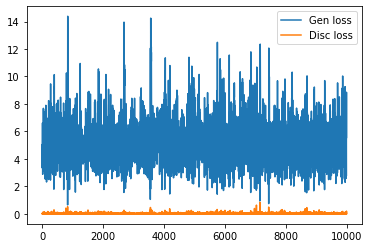

epoch: 17 	 step:0 	 loss: 3.922
epoch: 17 	 step:100 	 loss: 4.082
epoch: 17 	 step:200 	 loss: 4.399
epoch: 17 	 step:300 	 loss: 4.26
epoch: 17 	 step:400 	 loss: 6.719
epoch: 17 	 step:500 	 loss: 5.679
epoch: 17 	 step:600 	 loss: 5.825
epoch: 17 	 step:700 	 loss: 4.173
epoch: 17 	 step:800 	 loss: 7.753
epoch: 17 	 step:900 	 loss: 5.464
epoch: 17 	 step:1000 	 loss: 4.98
epoch: 17 	 step:1100 	 loss: 2.937
epoch: 17 	 step:1200 	 loss: 7.921
epoch: 17 	 step:1300 	 loss: 6.8
epoch: 17 	 step:1400 	 loss: 5.37
epoch: 17 	 step:1500 	 loss: 4.506
epoch: 17 	 step:1600 	 loss: 3.43
epoch: 17 	 step:1700 	 loss: 4.679
epoch: 17 	 step:1800 	 loss: 3.679


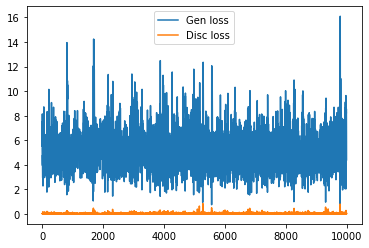

epoch: 18 	 step:0 	 loss: 3.76
epoch: 18 	 step:100 	 loss: 3.724
epoch: 18 	 step:200 	 loss: 5.686
epoch: 18 	 step:300 	 loss: 5.231
epoch: 18 	 step:400 	 loss: 4.217
epoch: 18 	 step:500 	 loss: 6.458
epoch: 18 	 step:600 	 loss: 4.527
epoch: 18 	 step:700 	 loss: 7.599
epoch: 18 	 step:800 	 loss: 7.173
epoch: 18 	 step:900 	 loss: 3.597
epoch: 18 	 step:1000 	 loss: 5.19
epoch: 18 	 step:1100 	 loss: 3.67
epoch: 18 	 step:1200 	 loss: 2.593
epoch: 18 	 step:1300 	 loss: 2.89
epoch: 18 	 step:1400 	 loss: 3.257
epoch: 18 	 step:1500 	 loss: 3.126
epoch: 18 	 step:1600 	 loss: 5.345
epoch: 18 	 step:1700 	 loss: 5.278
epoch: 18 	 step:1800 	 loss: 5.284


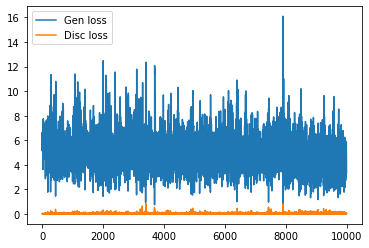

epoch: 19 	 step:0 	 loss: 3.386
epoch: 19 	 step:100 	 loss: 6.324
epoch: 19 	 step:200 	 loss: 5.547
epoch: 19 	 step:300 	 loss: 4.706
epoch: 19 	 step:400 	 loss: 5.08
epoch: 19 	 step:500 	 loss: 3.912
epoch: 19 	 step:600 	 loss: 3.334
epoch: 19 	 step:700 	 loss: 2.025
epoch: 19 	 step:800 	 loss: 3.118
epoch: 19 	 step:900 	 loss: 5.905
epoch: 19 	 step:1000 	 loss: 5.001
epoch: 19 	 step:1100 	 loss: 5.485
epoch: 19 	 step:1200 	 loss: 4.428
epoch: 19 	 step:1300 	 loss: 5.436
epoch: 19 	 step:1400 	 loss: 5.046
epoch: 19 	 step:1500 	 loss: 4.088
epoch: 19 	 step:1600 	 loss: 5.467
epoch: 19 	 step:1700 	 loss: 4.816
epoch: 19 	 step:1800 	 loss: 5.07


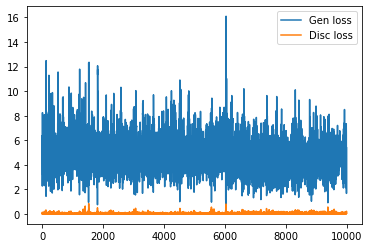

epoch: 20 	 step:0 	 loss: 7.857
epoch: 20 	 step:100 	 loss: 6.538
epoch: 20 	 step:200 	 loss: 3.938
epoch: 20 	 step:300 	 loss: 5.095
epoch: 20 	 step:400 	 loss: 4.534
epoch: 20 	 step:500 	 loss: 5.372
epoch: 20 	 step:600 	 loss: 4.433
epoch: 20 	 step:700 	 loss: 3.892
epoch: 20 	 step:800 	 loss: 7.187
epoch: 20 	 step:900 	 loss: 8.435
epoch: 20 	 step:1000 	 loss: 6.262
epoch: 20 	 step:1100 	 loss: 3.799
epoch: 20 	 step:1200 	 loss: 6.704
epoch: 20 	 step:1300 	 loss: 6.189
epoch: 20 	 step:1400 	 loss: 5.774
epoch: 20 	 step:1500 	 loss: 3.926
epoch: 20 	 step:1600 	 loss: 4.794
epoch: 20 	 step:1700 	 loss: 4.337
epoch: 20 	 step:1800 	 loss: 4.949


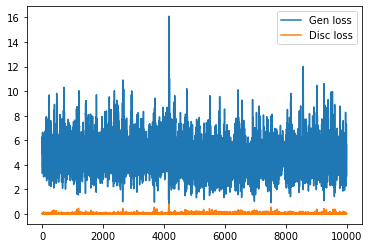

epoch: 21 	 step:0 	 loss: 4.902
epoch: 21 	 step:100 	 loss: 5.861
epoch: 21 	 step:200 	 loss: 3.218
epoch: 21 	 step:300 	 loss: 4.656
epoch: 21 	 step:400 	 loss: 3.982
epoch: 21 	 step:500 	 loss: 4.315
epoch: 21 	 step:600 	 loss: 3.76
epoch: 21 	 step:700 	 loss: 3.045
epoch: 21 	 step:800 	 loss: 5.322
epoch: 21 	 step:900 	 loss: 5.669
epoch: 21 	 step:1000 	 loss: 4.997
epoch: 21 	 step:1100 	 loss: 3.867
epoch: 21 	 step:1200 	 loss: 4.13
epoch: 21 	 step:1300 	 loss: 5.706
epoch: 21 	 step:1400 	 loss: 4.589
epoch: 21 	 step:1500 	 loss: 4.339
epoch: 21 	 step:1600 	 loss: 3.62
epoch: 21 	 step:1700 	 loss: 4.186
epoch: 21 	 step:1800 	 loss: 2.633


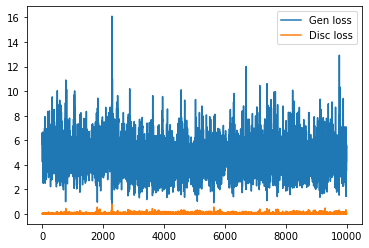

epoch: 22 	 step:0 	 loss: 5.286
epoch: 22 	 step:100 	 loss: 4.686
epoch: 22 	 step:200 	 loss: 5.496
epoch: 22 	 step:300 	 loss: 4.446
epoch: 22 	 step:400 	 loss: 6.68
epoch: 22 	 step:500 	 loss: 4.911
epoch: 22 	 step:600 	 loss: 5.116
epoch: 22 	 step:700 	 loss: 4.351
epoch: 22 	 step:800 	 loss: 4.524
epoch: 22 	 step:900 	 loss: 5.381
epoch: 22 	 step:1000 	 loss: 4.856
epoch: 22 	 step:1100 	 loss: 4.618
epoch: 22 	 step:1200 	 loss: 4.141
epoch: 22 	 step:1300 	 loss: 4.325
epoch: 22 	 step:1400 	 loss: 4.698
epoch: 22 	 step:1500 	 loss: 5.122
epoch: 22 	 step:1600 	 loss: 3.384
epoch: 22 	 step:1700 	 loss: 6.281
epoch: 22 	 step:1800 	 loss: 5.022


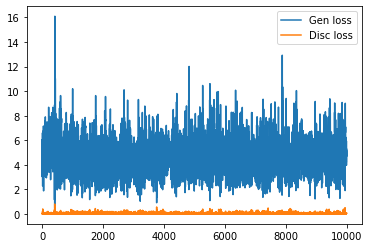

epoch: 23 	 step:0 	 loss: 1.57
epoch: 23 	 step:100 	 loss: 4.385
epoch: 23 	 step:200 	 loss: 5.912
epoch: 23 	 step:300 	 loss: 4.108
epoch: 23 	 step:400 	 loss: 5.372
epoch: 23 	 step:500 	 loss: 5.263
epoch: 23 	 step:600 	 loss: 3.863
epoch: 23 	 step:700 	 loss: 4.706
epoch: 23 	 step:800 	 loss: 5.391
epoch: 23 	 step:900 	 loss: 4.157
epoch: 23 	 step:1000 	 loss: 3.513
epoch: 23 	 step:1100 	 loss: 4.332
epoch: 23 	 step:1200 	 loss: 5.055
epoch: 23 	 step:1300 	 loss: 4.981
epoch: 23 	 step:1400 	 loss: 5.26
epoch: 23 	 step:1500 	 loss: 6.457
epoch: 23 	 step:1600 	 loss: 4.118
epoch: 23 	 step:1700 	 loss: 4.916
epoch: 23 	 step:1800 	 loss: 4.62


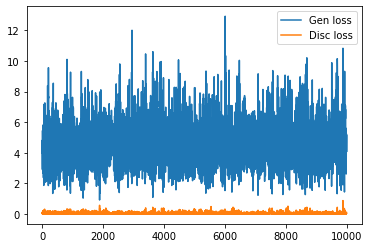

epoch: 24 	 step:0 	 loss: 3.207
epoch: 24 	 step:100 	 loss: 4.318
epoch: 24 	 step:200 	 loss: 4.577
epoch: 24 	 step:300 	 loss: 4.562
epoch: 24 	 step:400 	 loss: 5.865
epoch: 24 	 step:500 	 loss: 5.52
epoch: 24 	 step:600 	 loss: 4.34
epoch: 24 	 step:700 	 loss: 4.109
epoch: 24 	 step:800 	 loss: 3.155
epoch: 24 	 step:900 	 loss: 2.804
epoch: 24 	 step:1000 	 loss: 5.117
epoch: 24 	 step:1100 	 loss: 4.254
epoch: 24 	 step:1200 	 loss: 3.861
epoch: 24 	 step:1300 	 loss: 7.898
epoch: 24 	 step:1400 	 loss: 5.408
epoch: 24 	 step:1500 	 loss: 3.994
epoch: 24 	 step:1600 	 loss: 3.935
epoch: 24 	 step:1700 	 loss: 3.548
epoch: 24 	 step:1800 	 loss: 4.736


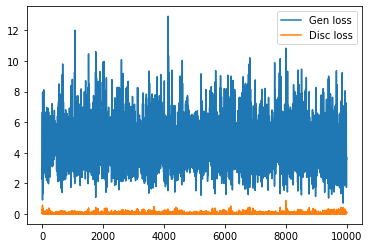

epoch: 25 	 step:0 	 loss: 3.951
epoch: 25 	 step:100 	 loss: 6.609
epoch: 25 	 step:200 	 loss: 5.813
epoch: 25 	 step:300 	 loss: 3.84
epoch: 25 	 step:400 	 loss: 5.029
epoch: 25 	 step:500 	 loss: 3.883
epoch: 25 	 step:600 	 loss: 4.442
epoch: 25 	 step:700 	 loss: 4.825
epoch: 25 	 step:800 	 loss: 3.777
epoch: 25 	 step:900 	 loss: 3.824
epoch: 25 	 step:1000 	 loss: 5.581
epoch: 25 	 step:1100 	 loss: 5.385
epoch: 25 	 step:1200 	 loss: 4.2
epoch: 25 	 step:1300 	 loss: 5.931
epoch: 25 	 step:1400 	 loss: 5.353
epoch: 25 	 step:1500 	 loss: 3.799
epoch: 25 	 step:1600 	 loss: 4.699
epoch: 25 	 step:1700 	 loss: 3.703
epoch: 25 	 step:1800 	 loss: 5.672


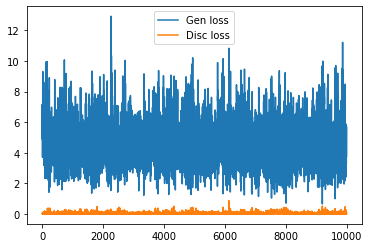

epoch: 26 	 step:0 	 loss: 4.065
epoch: 26 	 step:100 	 loss: 4.077
epoch: 26 	 step:200 	 loss: 3.667
epoch: 26 	 step:300 	 loss: 3.508
epoch: 26 	 step:400 	 loss: 3.586
epoch: 26 	 step:500 	 loss: 3.469
epoch: 26 	 step:600 	 loss: 2.922
epoch: 26 	 step:700 	 loss: 6.95
epoch: 26 	 step:800 	 loss: 3.249
epoch: 26 	 step:900 	 loss: 4.338
epoch: 26 	 step:1000 	 loss: 6.35
epoch: 26 	 step:1100 	 loss: 3.53
epoch: 26 	 step:1200 	 loss: 2.935
epoch: 26 	 step:1300 	 loss: 6.19
epoch: 26 	 step:1400 	 loss: 5.13
epoch: 26 	 step:1500 	 loss: 4.014
epoch: 26 	 step:1600 	 loss: 5.953
epoch: 26 	 step:1700 	 loss: 6.506
epoch: 26 	 step:1800 	 loss: 4.503


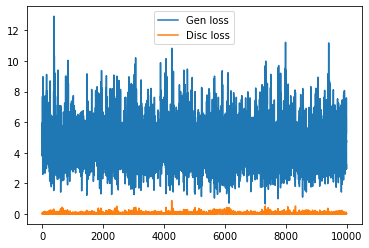

epoch: 27 	 step:0 	 loss: 3.943
epoch: 27 	 step:100 	 loss: 4.37
epoch: 27 	 step:200 	 loss: 7.778
epoch: 27 	 step:300 	 loss: 5.635
epoch: 27 	 step:400 	 loss: 5.009
epoch: 27 	 step:500 	 loss: 2.801
epoch: 27 	 step:600 	 loss: 5.544
epoch: 27 	 step:700 	 loss: 5.977
epoch: 27 	 step:800 	 loss: 5.435
epoch: 27 	 step:900 	 loss: 4.328
epoch: 27 	 step:1000 	 loss: 6.359
epoch: 27 	 step:1100 	 loss: 10.52
epoch: 27 	 step:1200 	 loss: 5.486
epoch: 27 	 step:1300 	 loss: 0.5951
epoch: 27 	 step:1400 	 loss: 4.047
epoch: 27 	 step:1500 	 loss: 2.2
epoch: 27 	 step:1600 	 loss: 3.517
epoch: 27 	 step:1700 	 loss: 3.685
epoch: 27 	 step:1800 	 loss: 2.812


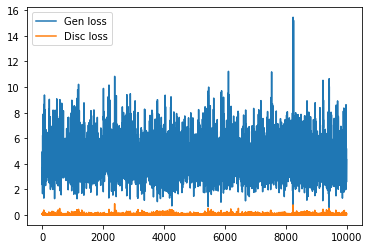

epoch: 28 	 step:0 	 loss: 3.445
epoch: 28 	 step:100 	 loss: 5.711
epoch: 28 	 step:200 	 loss: 2.819
epoch: 28 	 step:300 	 loss: 6.999
epoch: 28 	 step:400 	 loss: 6.15
epoch: 28 	 step:500 	 loss: 5.464
epoch: 28 	 step:600 	 loss: 6.54
epoch: 28 	 step:700 	 loss: 2.267
epoch: 28 	 step:800 	 loss: 4.95
epoch: 28 	 step:900 	 loss: 6.224
epoch: 28 	 step:1000 	 loss: 5.565
epoch: 28 	 step:1100 	 loss: 6.493
epoch: 28 	 step:1200 	 loss: 6.134
epoch: 28 	 step:1300 	 loss: 6.269
epoch: 28 	 step:1400 	 loss: 4.293
epoch: 28 	 step:1500 	 loss: 5.486
epoch: 28 	 step:1600 	 loss: 7.271
epoch: 28 	 step:1700 	 loss: 2.821
epoch: 28 	 step:1800 	 loss: 4.865


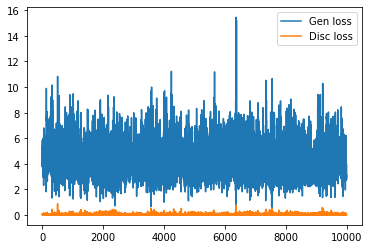

epoch: 29 	 step:0 	 loss: 4.031
epoch: 29 	 step:100 	 loss: 5.464
epoch: 29 	 step:200 	 loss: 7.167
epoch: 29 	 step:300 	 loss: 2.903
epoch: 29 	 step:400 	 loss: 5.388
epoch: 29 	 step:500 	 loss: 4.759
epoch: 29 	 step:600 	 loss: 6.576
epoch: 29 	 step:700 	 loss: 8.596
epoch: 29 	 step:800 	 loss: 5.818
epoch: 29 	 step:900 	 loss: 4.818
epoch: 29 	 step:1000 	 loss: 4.799
epoch: 29 	 step:1100 	 loss: 4.336
epoch: 29 	 step:1200 	 loss: 4.261
epoch: 29 	 step:1300 	 loss: 7.781
epoch: 29 	 step:1400 	 loss: 4.749
epoch: 29 	 step:1500 	 loss: 7.22
epoch: 29 	 step:1600 	 loss: 4.243
epoch: 29 	 step:1700 	 loss: 5.8
epoch: 29 	 step:1800 	 loss: 3.591


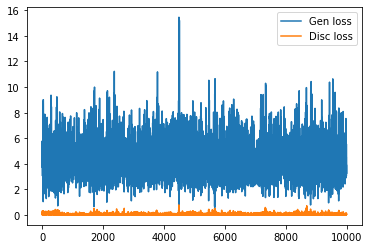

epoch: 30 	 step:0 	 loss: 3.925
epoch: 30 	 step:100 	 loss: 4.839
epoch: 30 	 step:200 	 loss: 3.632
epoch: 30 	 step:300 	 loss: 4.922
epoch: 30 	 step:400 	 loss: 6.283
epoch: 30 	 step:500 	 loss: 4.341
epoch: 30 	 step:600 	 loss: 5.679
epoch: 30 	 step:700 	 loss: 2.76
epoch: 30 	 step:800 	 loss: 4.659
epoch: 30 	 step:900 	 loss: 4.316
epoch: 30 	 step:1000 	 loss: 4.852
epoch: 30 	 step:1100 	 loss: 5.215
epoch: 30 	 step:1200 	 loss: 5.525
epoch: 30 	 step:1300 	 loss: 6.703
epoch: 30 	 step:1400 	 loss: 3.8
epoch: 30 	 step:1500 	 loss: 4.079
epoch: 30 	 step:1600 	 loss: 5.872
epoch: 30 	 step:1700 	 loss: 5.582
epoch: 30 	 step:1800 	 loss: 4.689


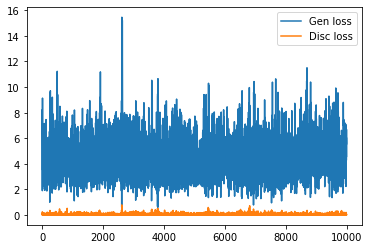

epoch: 31 	 step:0 	 loss: 4.506
epoch: 31 	 step:100 	 loss: 3.291
epoch: 31 	 step:200 	 loss: 8.745
epoch: 31 	 step:300 	 loss: 2.774
epoch: 31 	 step:400 	 loss: 5.747
epoch: 31 	 step:500 	 loss: 3.847
epoch: 31 	 step:600 	 loss: 5.97
epoch: 31 	 step:700 	 loss: 4.938
epoch: 31 	 step:800 	 loss: 6.22
epoch: 31 	 step:900 	 loss: 5.359
epoch: 31 	 step:1000 	 loss: 5.174
epoch: 31 	 step:1100 	 loss: 3.703
epoch: 31 	 step:1200 	 loss: 5.154
epoch: 31 	 step:1300 	 loss: 4.125
epoch: 31 	 step:1400 	 loss: 3.797
epoch: 31 	 step:1500 	 loss: 5.471
epoch: 31 	 step:1600 	 loss: 6.218
epoch: 31 	 step:1700 	 loss: 5.832
epoch: 31 	 step:1800 	 loss: 4.371


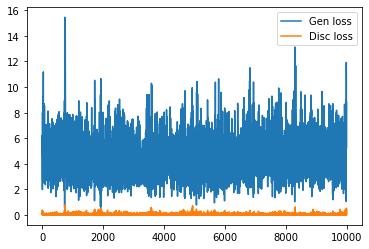

epoch: 32 	 step:0 	 loss: 10.01
epoch: 32 	 step:100 	 loss: 6.488
epoch: 32 	 step:200 	 loss: 5.808
epoch: 32 	 step:300 	 loss: 6.07
epoch: 32 	 step:400 	 loss: 3.997
epoch: 32 	 step:500 	 loss: 7.565
epoch: 32 	 step:600 	 loss: 3.878
epoch: 32 	 step:700 	 loss: 5.043
epoch: 32 	 step:800 	 loss: 5.167
epoch: 32 	 step:900 	 loss: 4.551
epoch: 32 	 step:1000 	 loss: 4.441
epoch: 32 	 step:1100 	 loss: 7.398
epoch: 32 	 step:1200 	 loss: 2.129
epoch: 32 	 step:1300 	 loss: 5.329
epoch: 32 	 step:1400 	 loss: 4.382
epoch: 32 	 step:1500 	 loss: 4.912
epoch: 32 	 step:1600 	 loss: 4.269
epoch: 32 	 step:1700 	 loss: 3.296
epoch: 32 	 step:1800 	 loss: 4.966


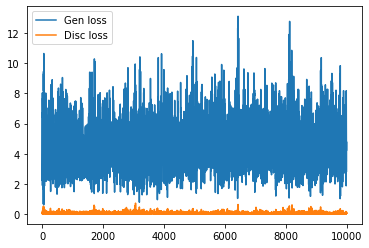

epoch: 33 	 step:0 	 loss: 6.61
epoch: 33 	 step:100 	 loss: 3.445
epoch: 33 	 step:200 	 loss: 3.452
epoch: 33 	 step:300 	 loss: 6.79
epoch: 33 	 step:400 	 loss: 4.819
epoch: 33 	 step:500 	 loss: 8.025
epoch: 33 	 step:600 	 loss: 2.421
epoch: 33 	 step:700 	 loss: 2.911
epoch: 33 	 step:800 	 loss: 4.0
epoch: 33 	 step:900 	 loss: 3.302
epoch: 33 	 step:1000 	 loss: 4.494
epoch: 33 	 step:1100 	 loss: 3.292
epoch: 33 	 step:1200 	 loss: 3.198
epoch: 33 	 step:1300 	 loss: 5.258
epoch: 33 	 step:1400 	 loss: 5.624
epoch: 33 	 step:1500 	 loss: 5.752
epoch: 33 	 step:1600 	 loss: 7.45
epoch: 33 	 step:1700 	 loss: 7.037
epoch: 33 	 step:1800 	 loss: 4.702


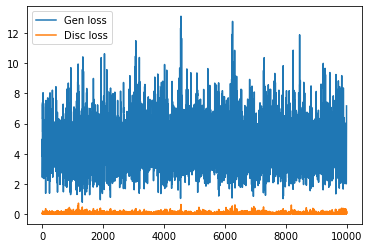

epoch: 34 	 step:0 	 loss: 5.196
epoch: 34 	 step:100 	 loss: 8.508
epoch: 34 	 step:200 	 loss: 5.298
epoch: 34 	 step:300 	 loss: 4.52
epoch: 34 	 step:400 	 loss: 3.607
epoch: 34 	 step:500 	 loss: 5.351
epoch: 34 	 step:600 	 loss: 4.144
epoch: 34 	 step:700 	 loss: 2.958
epoch: 34 	 step:800 	 loss: 4.073
epoch: 34 	 step:900 	 loss: 5.788
epoch: 34 	 step:1000 	 loss: 1.802
epoch: 34 	 step:1100 	 loss: 6.246
epoch: 34 	 step:1200 	 loss: 4.039
epoch: 34 	 step:1300 	 loss: 6.659
epoch: 34 	 step:1400 	 loss: 3.036
epoch: 34 	 step:1500 	 loss: 4.466
epoch: 34 	 step:1600 	 loss: 4.396
epoch: 34 	 step:1700 	 loss: 4.704
epoch: 34 	 step:1800 	 loss: 3.853


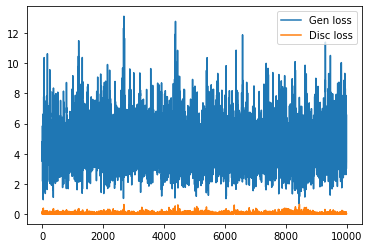

epoch: 35 	 step:0 	 loss: 6.016
epoch: 35 	 step:100 	 loss: 3.801
epoch: 35 	 step:200 	 loss: 5.565
epoch: 35 	 step:300 	 loss: 3.942
epoch: 35 	 step:400 	 loss: 3.933
epoch: 35 	 step:500 	 loss: 5.254
epoch: 35 	 step:600 	 loss: 5.082
epoch: 35 	 step:700 	 loss: 4.964
epoch: 35 	 step:800 	 loss: 6.029
epoch: 35 	 step:900 	 loss: 4.199
epoch: 35 	 step:1000 	 loss: 5.808
epoch: 35 	 step:1100 	 loss: 7.689
epoch: 35 	 step:1200 	 loss: 2.843
epoch: 35 	 step:1300 	 loss: 3.836
epoch: 35 	 step:1400 	 loss: 5.321
epoch: 35 	 step:1500 	 loss: 5.569
epoch: 35 	 step:1600 	 loss: 6.476
epoch: 35 	 step:1700 	 loss: 6.715
epoch: 35 	 step:1800 	 loss: 2.613


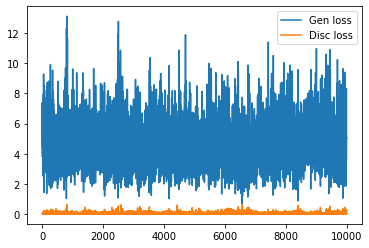

epoch: 36 	 step:0 	 loss: 3.28
epoch: 36 	 step:100 	 loss: 9.415
epoch: 36 	 step:200 	 loss: 6.579
epoch: 36 	 step:300 	 loss: 7.378
epoch: 36 	 step:400 	 loss: 4.328
epoch: 36 	 step:500 	 loss: 5.876
epoch: 36 	 step:600 	 loss: 4.789
epoch: 36 	 step:700 	 loss: 4.353
epoch: 36 	 step:800 	 loss: 2.831
epoch: 36 	 step:900 	 loss: 3.431
epoch: 36 	 step:1000 	 loss: 3.017
epoch: 36 	 step:1100 	 loss: 3.662
epoch: 36 	 step:1200 	 loss: 4.194
epoch: 36 	 step:1300 	 loss: 4.886
epoch: 36 	 step:1400 	 loss: 4.348
epoch: 36 	 step:1500 	 loss: 3.93
epoch: 36 	 step:1600 	 loss: 4.276
epoch: 36 	 step:1700 	 loss: 4.789
epoch: 36 	 step:1800 	 loss: 5.009


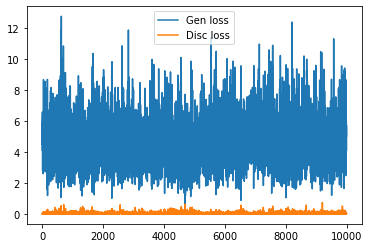

epoch: 37 	 step:0 	 loss: 3.915
epoch: 37 	 step:100 	 loss: 3.041
epoch: 37 	 step:200 	 loss: 4.289
epoch: 37 	 step:300 	 loss: 3.798
epoch: 37 	 step:400 	 loss: 5.848
epoch: 37 	 step:500 	 loss: 4.427
epoch: 37 	 step:600 	 loss: 5.264
epoch: 37 	 step:700 	 loss: 3.415
epoch: 37 	 step:800 	 loss: 6.581
epoch: 37 	 step:900 	 loss: 5.318
epoch: 37 	 step:1000 	 loss: 3.124
epoch: 37 	 step:1100 	 loss: 3.682
epoch: 37 	 step:1200 	 loss: 8.822
epoch: 37 	 step:1300 	 loss: 4.384
epoch: 37 	 step:1400 	 loss: 4.955
epoch: 37 	 step:1500 	 loss: 5.2
epoch: 37 	 step:1600 	 loss: 4.312
epoch: 37 	 step:1700 	 loss: 6.453
epoch: 37 	 step:1800 	 loss: 8.072


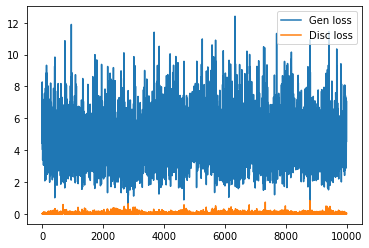

epoch: 38 	 step:0 	 loss: 5.199
epoch: 38 	 step:100 	 loss: 7.127
epoch: 38 	 step:200 	 loss: 5.83
epoch: 38 	 step:300 	 loss: 7.295
epoch: 38 	 step:400 	 loss: 5.764
epoch: 38 	 step:500 	 loss: 5.432
epoch: 38 	 step:600 	 loss: 5.368
epoch: 38 	 step:700 	 loss: 4.071
epoch: 38 	 step:800 	 loss: 5.124
epoch: 38 	 step:900 	 loss: 4.935
epoch: 38 	 step:1000 	 loss: 4.162
epoch: 38 	 step:1100 	 loss: 4.673
epoch: 38 	 step:1200 	 loss: 3.646
epoch: 38 	 step:1300 	 loss: 4.922
epoch: 38 	 step:1400 	 loss: 4.353
epoch: 38 	 step:1500 	 loss: 4.457
epoch: 38 	 step:1600 	 loss: 1.894
epoch: 38 	 step:1700 	 loss: 4.465
epoch: 38 	 step:1800 	 loss: 4.143


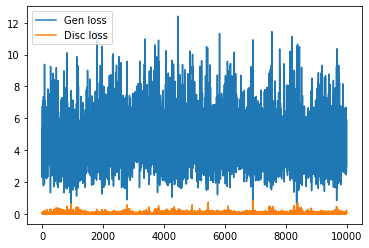

epoch: 39 	 step:0 	 loss: 3.152
epoch: 39 	 step:100 	 loss: 2.332
epoch: 39 	 step:200 	 loss: 2.794
epoch: 39 	 step:300 	 loss: 3.876
epoch: 39 	 step:400 	 loss: 6.639
epoch: 39 	 step:500 	 loss: 4.683
epoch: 39 	 step:600 	 loss: 5.047
epoch: 39 	 step:700 	 loss: 3.838
epoch: 39 	 step:800 	 loss: 3.501
epoch: 39 	 step:900 	 loss: 3.31
epoch: 39 	 step:1000 	 loss: 6.657
epoch: 39 	 step:1100 	 loss: 5.336
epoch: 39 	 step:1200 	 loss: 4.577
epoch: 39 	 step:1300 	 loss: 4.086
epoch: 39 	 step:1400 	 loss: 4.748
epoch: 39 	 step:1500 	 loss: 6.678
epoch: 39 	 step:1600 	 loss: 6.735
epoch: 39 	 step:1700 	 loss: 2.876
epoch: 39 	 step:1800 	 loss: 7.351


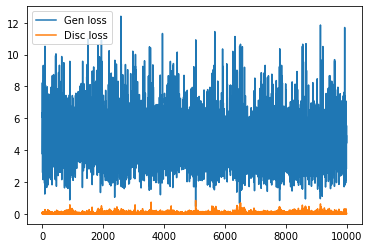

epoch: 40 	 step:0 	 loss: 5.324
epoch: 40 	 step:100 	 loss: 7.219
epoch: 40 	 step:200 	 loss: 5.671
epoch: 40 	 step:300 	 loss: 4.284
epoch: 40 	 step:400 	 loss: 5.261
epoch: 40 	 step:500 	 loss: 3.877
epoch: 40 	 step:600 	 loss: 5.296
epoch: 40 	 step:700 	 loss: 5.245
epoch: 40 	 step:800 	 loss: 4.036
epoch: 40 	 step:900 	 loss: 2.975
epoch: 40 	 step:1000 	 loss: 6.709
epoch: 40 	 step:1100 	 loss: 2.46
epoch: 40 	 step:1200 	 loss: 2.322
epoch: 40 	 step:1300 	 loss: 5.892
epoch: 40 	 step:1400 	 loss: 4.557
epoch: 40 	 step:1500 	 loss: 4.735
epoch: 40 	 step:1600 	 loss: 8.06
epoch: 40 	 step:1700 	 loss: 7.013
epoch: 40 	 step:1800 	 loss: 3.499


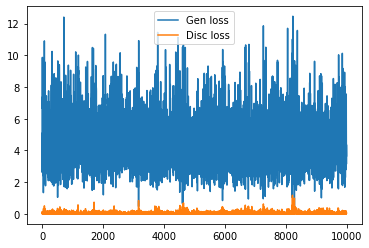

epoch: 41 	 step:0 	 loss: 3.908
epoch: 41 	 step:100 	 loss: 5.162
epoch: 41 	 step:200 	 loss: 4.068
epoch: 41 	 step:300 	 loss: 3.004
epoch: 41 	 step:400 	 loss: 9.211
epoch: 41 	 step:500 	 loss: 4.14
epoch: 41 	 step:600 	 loss: 3.985
epoch: 41 	 step:700 	 loss: 6.124
epoch: 41 	 step:800 	 loss: 4.354
epoch: 41 	 step:900 	 loss: 3.978
epoch: 41 	 step:1000 	 loss: 7.238
epoch: 41 	 step:1100 	 loss: 5.583
epoch: 41 	 step:1200 	 loss: 7.784
epoch: 41 	 step:1300 	 loss: 3.29
epoch: 41 	 step:1400 	 loss: 3.875
epoch: 41 	 step:1500 	 loss: 4.699
epoch: 41 	 step:1600 	 loss: 7.438
epoch: 41 	 step:1700 	 loss: 8.288
epoch: 41 	 step:1800 	 loss: 5.745


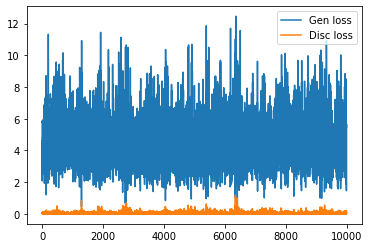

epoch: 42 	 step:0 	 loss: 8.146
epoch: 42 	 step:100 	 loss: 7.349
epoch: 42 	 step:200 	 loss: 3.366
epoch: 42 	 step:300 	 loss: 5.799
epoch: 42 	 step:400 	 loss: 3.282
epoch: 42 	 step:500 	 loss: 7.828
epoch: 42 	 step:600 	 loss: 5.215
epoch: 42 	 step:700 	 loss: 2.68
epoch: 42 	 step:800 	 loss: 6.978
epoch: 42 	 step:900 	 loss: 5.852
epoch: 42 	 step:1000 	 loss: 3.656
epoch: 42 	 step:1100 	 loss: 4.505
epoch: 42 	 step:1200 	 loss: 7.13
epoch: 42 	 step:1300 	 loss: 8.24
epoch: 42 	 step:1400 	 loss: 4.592
epoch: 42 	 step:1500 	 loss: 3.003
epoch: 42 	 step:1600 	 loss: 5.31
epoch: 42 	 step:1700 	 loss: 4.04
epoch: 42 	 step:1800 	 loss: 5.158


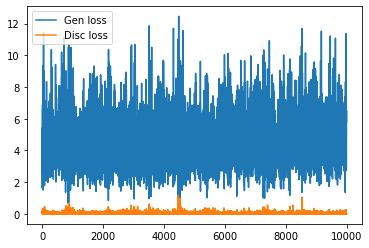

epoch: 43 	 step:0 	 loss: 7.087
epoch: 43 	 step:100 	 loss: 4.68
epoch: 43 	 step:200 	 loss: 4.29
epoch: 43 	 step:300 	 loss: 6.016
epoch: 43 	 step:400 	 loss: 5.586
epoch: 43 	 step:500 	 loss: 3.812
epoch: 43 	 step:600 	 loss: 2.887
epoch: 43 	 step:700 	 loss: 4.126
epoch: 43 	 step:800 	 loss: 6.716
epoch: 43 	 step:900 	 loss: 4.552
epoch: 43 	 step:1000 	 loss: 2.852
epoch: 43 	 step:1100 	 loss: 4.321
epoch: 43 	 step:1200 	 loss: 5.185
epoch: 43 	 step:1300 	 loss: 3.452
epoch: 43 	 step:1400 	 loss: 3.996
epoch: 43 	 step:1500 	 loss: 4.635
epoch: 43 	 step:1600 	 loss: 4.747
epoch: 43 	 step:1700 	 loss: 5.112
epoch: 43 	 step:1800 	 loss: 5.138


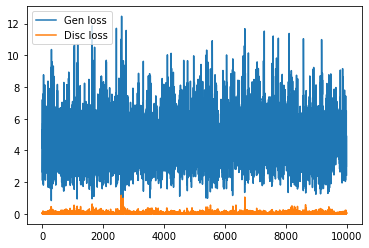

epoch: 44 	 step:0 	 loss: 5.386
epoch: 44 	 step:100 	 loss: 5.678
epoch: 44 	 step:200 	 loss: 4.537
epoch: 44 	 step:300 	 loss: 5.759
epoch: 44 	 step:400 	 loss: 6.105
epoch: 44 	 step:500 	 loss: 4.051
epoch: 44 	 step:600 	 loss: 3.981
epoch: 44 	 step:700 	 loss: 5.111
epoch: 44 	 step:800 	 loss: 3.612
epoch: 44 	 step:900 	 loss: 2.633
epoch: 44 	 step:1000 	 loss: 4.546
epoch: 44 	 step:1100 	 loss: 3.62
epoch: 44 	 step:1200 	 loss: 3.205
epoch: 44 	 step:1300 	 loss: 5.815
epoch: 44 	 step:1400 	 loss: 7.047
epoch: 44 	 step:1500 	 loss: 3.69
epoch: 44 	 step:1600 	 loss: 6.463
epoch: 44 	 step:1700 	 loss: 2.199
epoch: 44 	 step:1800 	 loss: 5.32


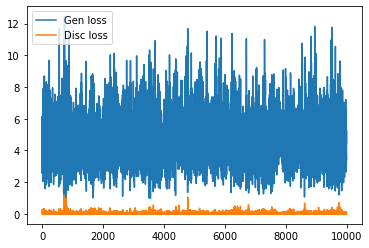

epoch: 45 	 step:0 	 loss: 6.123
epoch: 45 	 step:100 	 loss: 6.385
epoch: 45 	 step:200 	 loss: 5.0
epoch: 45 	 step:300 	 loss: 9.135
epoch: 45 	 step:400 	 loss: 4.828
epoch: 45 	 step:500 	 loss: 4.224
epoch: 45 	 step:600 	 loss: 6.438
epoch: 45 	 step:700 	 loss: 1.761
epoch: 45 	 step:800 	 loss: 5.076
epoch: 45 	 step:900 	 loss: 3.919
epoch: 45 	 step:1000 	 loss: 3.731
epoch: 45 	 step:1100 	 loss: 4.177
epoch: 45 	 step:1200 	 loss: 5.134
epoch: 45 	 step:1300 	 loss: 2.962
epoch: 45 	 step:1400 	 loss: 2.862
epoch: 45 	 step:1500 	 loss: 7.325
epoch: 45 	 step:1600 	 loss: 3.479
epoch: 45 	 step:1700 	 loss: 6.788
epoch: 45 	 step:1800 	 loss: 4.668


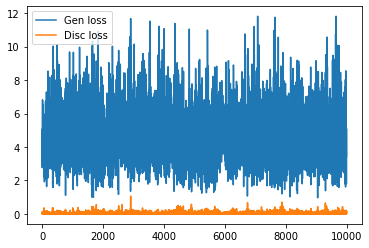

epoch: 46 	 step:0 	 loss: 2.845
epoch: 46 	 step:100 	 loss: 6.217
epoch: 46 	 step:200 	 loss: 4.474
epoch: 46 	 step:300 	 loss: 4.513
epoch: 46 	 step:400 	 loss: 7.028
epoch: 46 	 step:500 	 loss: 7.499
epoch: 46 	 step:600 	 loss: 5.863
epoch: 46 	 step:700 	 loss: 2.404
epoch: 46 	 step:800 	 loss: 1.954
epoch: 46 	 step:900 	 loss: 5.839
epoch: 46 	 step:1000 	 loss: 5.569
epoch: 46 	 step:1100 	 loss: 7.509
epoch: 46 	 step:1200 	 loss: 3.344
epoch: 46 	 step:1300 	 loss: 7.259
epoch: 46 	 step:1400 	 loss: 5.916
epoch: 46 	 step:1500 	 loss: 4.398
epoch: 46 	 step:1600 	 loss: 4.679
epoch: 46 	 step:1700 	 loss: 4.831
epoch: 46 	 step:1800 	 loss: 3.774


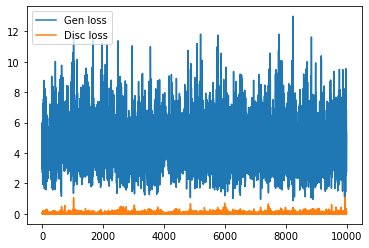

epoch: 47 	 step:0 	 loss: 4.443
epoch: 47 	 step:100 	 loss: 3.419
epoch: 47 	 step:200 	 loss: 5.552
epoch: 47 	 step:300 	 loss: 7.096
epoch: 47 	 step:400 	 loss: 5.523
epoch: 47 	 step:500 	 loss: 2.564
epoch: 47 	 step:600 	 loss: 5.233
epoch: 47 	 step:700 	 loss: 5.744
epoch: 47 	 step:800 	 loss: 5.254
epoch: 47 	 step:900 	 loss: 3.63
epoch: 47 	 step:1000 	 loss: 4.36
epoch: 47 	 step:1100 	 loss: 3.361
epoch: 47 	 step:1200 	 loss: 2.918
epoch: 47 	 step:1300 	 loss: 6.095
epoch: 47 	 step:1400 	 loss: 4.416
epoch: 47 	 step:1500 	 loss: 3.06
epoch: 47 	 step:1600 	 loss: 2.289
epoch: 47 	 step:1700 	 loss: 4.649
epoch: 47 	 step:1800 	 loss: 5.166


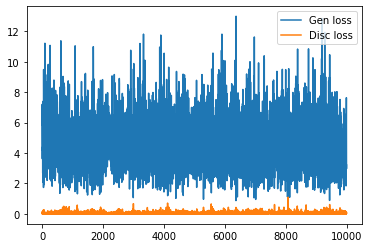

epoch: 48 	 step:0 	 loss: 3.275
epoch: 48 	 step:100 	 loss: 4.286
epoch: 48 	 step:200 	 loss: 7.629
epoch: 48 	 step:300 	 loss: 1.456
epoch: 48 	 step:400 	 loss: 4.803
epoch: 48 	 step:500 	 loss: 4.568
epoch: 48 	 step:600 	 loss: 5.452
epoch: 48 	 step:700 	 loss: 5.031
epoch: 48 	 step:800 	 loss: 3.533
epoch: 48 	 step:900 	 loss: 6.286
epoch: 48 	 step:1000 	 loss: 3.774
epoch: 48 	 step:1100 	 loss: 4.551
epoch: 48 	 step:1200 	 loss: 5.931
epoch: 48 	 step:1300 	 loss: 4.652
epoch: 48 	 step:1400 	 loss: 6.573
epoch: 48 	 step:1500 	 loss: 5.664
epoch: 48 	 step:1600 	 loss: 3.816
epoch: 48 	 step:1700 	 loss: 4.628
epoch: 48 	 step:1800 	 loss: 7.868


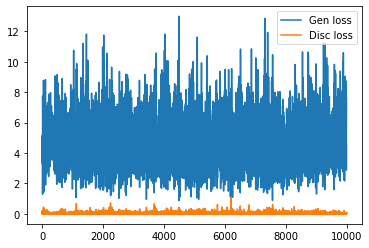

epoch: 49 	 step:0 	 loss: 5.891
epoch: 49 	 step:100 	 loss: 1.987
epoch: 49 	 step:200 	 loss: 3.535
epoch: 49 	 step:300 	 loss: 5.248
epoch: 49 	 step:400 	 loss: 4.341
epoch: 49 	 step:500 	 loss: 4.382
epoch: 49 	 step:600 	 loss: 3.403
epoch: 49 	 step:700 	 loss: 4.808
epoch: 49 	 step:800 	 loss: 3.313
epoch: 49 	 step:900 	 loss: 2.696
epoch: 49 	 step:1000 	 loss: 3.667
epoch: 49 	 step:1100 	 loss: 4.536
epoch: 49 	 step:1200 	 loss: 1.774
epoch: 49 	 step:1300 	 loss: 5.043
epoch: 49 	 step:1400 	 loss: 3.066
epoch: 49 	 step:1500 	 loss: 3.61
epoch: 49 	 step:1600 	 loss: 3.114
epoch: 49 	 step:1700 	 loss: 4.133
epoch: 49 	 step:1800 	 loss: 3.747


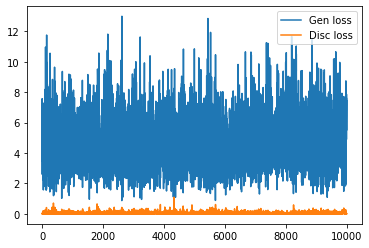

epoch: 50 	 step:0 	 loss: 3.076
epoch: 50 	 step:100 	 loss: 4.754
epoch: 50 	 step:200 	 loss: 4.204
epoch: 50 	 step:300 	 loss: 5.007
epoch: 50 	 step:400 	 loss: 4.09
epoch: 50 	 step:500 	 loss: 5.822
epoch: 50 	 step:600 	 loss: 12.0
epoch: 50 	 step:700 	 loss: 3.255
epoch: 50 	 step:800 	 loss: 5.154
epoch: 50 	 step:900 	 loss: 4.523
epoch: 50 	 step:1000 	 loss: 4.352
epoch: 50 	 step:1100 	 loss: 3.465
epoch: 50 	 step:1200 	 loss: 3.943
epoch: 50 	 step:1300 	 loss: 4.772
epoch: 50 	 step:1400 	 loss: 6.414
epoch: 50 	 step:1500 	 loss: 4.479
epoch: 50 	 step:1600 	 loss: 6.358
epoch: 50 	 step:1700 	 loss: 4.919
epoch: 50 	 step:1800 	 loss: 5.087


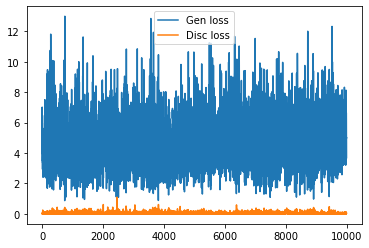

epoch: 51 	 step:0 	 loss: 7.102
epoch: 51 	 step:100 	 loss: 3.31
epoch: 51 	 step:200 	 loss: 6.154
epoch: 51 	 step:300 	 loss: 6.124
epoch: 51 	 step:400 	 loss: 3.604
epoch: 51 	 step:500 	 loss: 4.116
epoch: 51 	 step:600 	 loss: 4.158
epoch: 51 	 step:700 	 loss: 4.976
epoch: 51 	 step:800 	 loss: 3.458
epoch: 51 	 step:900 	 loss: 6.37
epoch: 51 	 step:1000 	 loss: 7.016
epoch: 51 	 step:1100 	 loss: 6.198
epoch: 51 	 step:1200 	 loss: 5.462
epoch: 51 	 step:1300 	 loss: 7.921
epoch: 51 	 step:1400 	 loss: 9.895
epoch: 51 	 step:1500 	 loss: 4.447
epoch: 51 	 step:1600 	 loss: 7.888
epoch: 51 	 step:1700 	 loss: 5.832
epoch: 51 	 step:1800 	 loss: 3.807


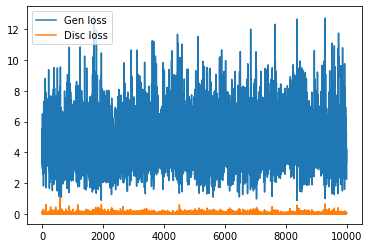

epoch: 52 	 step:0 	 loss: 5.13
epoch: 52 	 step:100 	 loss: 8.462
epoch: 52 	 step:200 	 loss: 5.686
epoch: 52 	 step:300 	 loss: 6.301
epoch: 52 	 step:400 	 loss: 2.3
epoch: 52 	 step:500 	 loss: 5.361
epoch: 52 	 step:600 	 loss: 6.303
epoch: 52 	 step:700 	 loss: 3.983
epoch: 52 	 step:800 	 loss: 4.587
epoch: 52 	 step:900 	 loss: 7.233
epoch: 52 	 step:1000 	 loss: 6.701
epoch: 52 	 step:1100 	 loss: 4.768
epoch: 52 	 step:1200 	 loss: 3.141
epoch: 52 	 step:1300 	 loss: 2.697
epoch: 52 	 step:1400 	 loss: 4.796
epoch: 52 	 step:1500 	 loss: 6.486
epoch: 52 	 step:1600 	 loss: 5.194
epoch: 52 	 step:1700 	 loss: 3.525
epoch: 52 	 step:1800 	 loss: 3.215


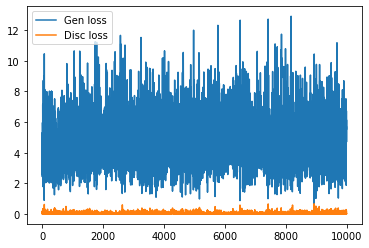

epoch: 53 	 step:0 	 loss: 3.911
epoch: 53 	 step:100 	 loss: 10.35
epoch: 53 	 step:200 	 loss: 5.026
epoch: 53 	 step:300 	 loss: 5.125
epoch: 53 	 step:400 	 loss: 3.929
epoch: 53 	 step:500 	 loss: 3.795
epoch: 53 	 step:600 	 loss: 6.035
epoch: 53 	 step:700 	 loss: 4.263
epoch: 53 	 step:800 	 loss: 4.285
epoch: 53 	 step:900 	 loss: 7.629
epoch: 53 	 step:1000 	 loss: 3.306
epoch: 53 	 step:1100 	 loss: 8.195
epoch: 53 	 step:1200 	 loss: 6.085
epoch: 53 	 step:1300 	 loss: 6.592
epoch: 53 	 step:1400 	 loss: 4.367
epoch: 53 	 step:1500 	 loss: 8.18
epoch: 53 	 step:1600 	 loss: 6.082
epoch: 53 	 step:1700 	 loss: 5.342
epoch: 53 	 step:1800 	 loss: 7.207


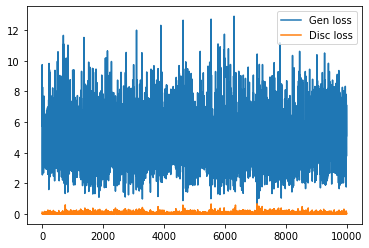

epoch: 54 	 step:0 	 loss: 9.124
epoch: 54 	 step:100 	 loss: 5.292
epoch: 54 	 step:200 	 loss: 4.137
epoch: 54 	 step:300 	 loss: 4.914
epoch: 54 	 step:400 	 loss: 5.166
epoch: 54 	 step:500 	 loss: 2.357
epoch: 54 	 step:600 	 loss: 4.091
epoch: 54 	 step:700 	 loss: 6.039
epoch: 54 	 step:800 	 loss: 4.194
epoch: 54 	 step:900 	 loss: 4.799
epoch: 54 	 step:1000 	 loss: 4.775
epoch: 54 	 step:1100 	 loss: 4.515
epoch: 54 	 step:1200 	 loss: 5.865
epoch: 54 	 step:1300 	 loss: 3.472
epoch: 54 	 step:1400 	 loss: 4.08
epoch: 54 	 step:1500 	 loss: 3.792
epoch: 54 	 step:1600 	 loss: 4.573
epoch: 54 	 step:1700 	 loss: 2.809
epoch: 54 	 step:1800 	 loss: 6.403


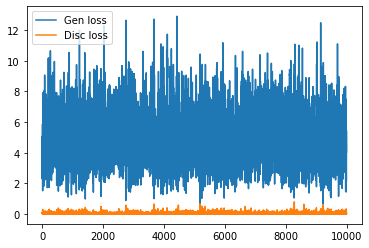

epoch: 55 	 step:0 	 loss: 5.034
epoch: 55 	 step:100 	 loss: 4.433
epoch: 55 	 step:200 	 loss: 3.84
epoch: 55 	 step:300 	 loss: 4.003
epoch: 55 	 step:400 	 loss: 6.377
epoch: 55 	 step:500 	 loss: 3.694
epoch: 55 	 step:600 	 loss: 4.621
epoch: 55 	 step:700 	 loss: 5.147
epoch: 55 	 step:800 	 loss: 4.062
epoch: 55 	 step:900 	 loss: 7.721
epoch: 55 	 step:1000 	 loss: 5.573
epoch: 55 	 step:1100 	 loss: 6.316
epoch: 55 	 step:1200 	 loss: 7.101
epoch: 55 	 step:1300 	 loss: 4.987
epoch: 55 	 step:1400 	 loss: 4.287
epoch: 55 	 step:1500 	 loss: 3.557
epoch: 55 	 step:1600 	 loss: 5.243
epoch: 55 	 step:1700 	 loss: 3.888
epoch: 55 	 step:1800 	 loss: 10.13


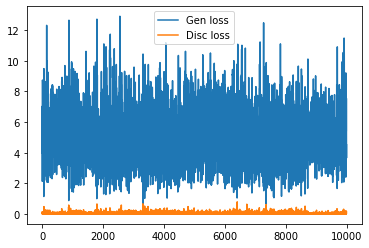

epoch: 56 	 step:0 	 loss: 3.615
epoch: 56 	 step:100 	 loss: 4.139
epoch: 56 	 step:200 	 loss: 6.008
epoch: 56 	 step:300 	 loss: 5.189
epoch: 56 	 step:400 	 loss: 2.091
epoch: 56 	 step:500 	 loss: 3.135
epoch: 56 	 step:600 	 loss: 3.581
epoch: 56 	 step:700 	 loss: 2.468
epoch: 56 	 step:800 	 loss: 4.469
epoch: 56 	 step:900 	 loss: 6.115
epoch: 56 	 step:1000 	 loss: 3.02
epoch: 56 	 step:1100 	 loss: 6.033
epoch: 56 	 step:1200 	 loss: 4.958
epoch: 56 	 step:1300 	 loss: 6.08
epoch: 56 	 step:1400 	 loss: 7.035
epoch: 56 	 step:1500 	 loss: 1.666
epoch: 56 	 step:1600 	 loss: 2.967
epoch: 56 	 step:1700 	 loss: 3.166
epoch: 56 	 step:1800 	 loss: 4.009


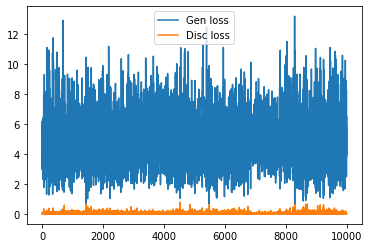

epoch: 57 	 step:0 	 loss: 5.302
epoch: 57 	 step:100 	 loss: 4.589
epoch: 57 	 step:200 	 loss: 8.387
epoch: 57 	 step:300 	 loss: 3.045
epoch: 57 	 step:400 	 loss: 9.231
epoch: 57 	 step:500 	 loss: 5.73
epoch: 57 	 step:600 	 loss: 7.218
epoch: 57 	 step:700 	 loss: 4.684
epoch: 57 	 step:800 	 loss: 7.338
epoch: 57 	 step:900 	 loss: 4.927
epoch: 57 	 step:1000 	 loss: 5.278
epoch: 57 	 step:1100 	 loss: 6.175
epoch: 57 	 step:1200 	 loss: 6.267
epoch: 57 	 step:1300 	 loss: 3.507
epoch: 57 	 step:1400 	 loss: 6.458
epoch: 57 	 step:1500 	 loss: 5.496
epoch: 57 	 step:1600 	 loss: 5.035
epoch: 57 	 step:1700 	 loss: 5.444
epoch: 57 	 step:1800 	 loss: 4.505


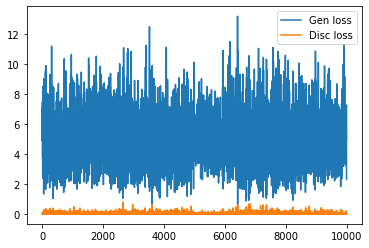

epoch: 58 	 step:0 	 loss: 3.394
epoch: 58 	 step:100 	 loss: 4.695
epoch: 58 	 step:200 	 loss: 3.473
epoch: 58 	 step:300 	 loss: 6.541
epoch: 58 	 step:400 	 loss: 5.759
epoch: 58 	 step:500 	 loss: 6.069
epoch: 58 	 step:600 	 loss: 2.744
epoch: 58 	 step:700 	 loss: 4.662
epoch: 58 	 step:800 	 loss: 5.714
epoch: 58 	 step:900 	 loss: 4.582
epoch: 58 	 step:1000 	 loss: 5.339
epoch: 58 	 step:1100 	 loss: 6.85
epoch: 58 	 step:1200 	 loss: 8.112
epoch: 58 	 step:1300 	 loss: 5.153
epoch: 58 	 step:1400 	 loss: 6.62
epoch: 58 	 step:1500 	 loss: 5.345
epoch: 58 	 step:1600 	 loss: 4.256
epoch: 58 	 step:1700 	 loss: 4.893
epoch: 58 	 step:1800 	 loss: 6.866


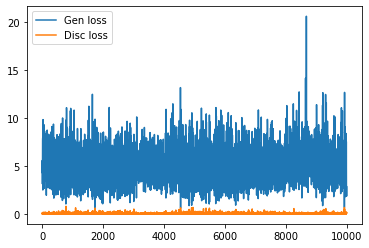

epoch: 59 	 step:0 	 loss: 4.301
epoch: 59 	 step:100 	 loss: 4.263
epoch: 59 	 step:200 	 loss: 4.767
epoch: 59 	 step:300 	 loss: 5.012
epoch: 59 	 step:400 	 loss: 5.954
epoch: 59 	 step:500 	 loss: 2.754
epoch: 59 	 step:600 	 loss: 6.866
epoch: 59 	 step:700 	 loss: 5.728
epoch: 59 	 step:800 	 loss: 5.429
epoch: 59 	 step:900 	 loss: 3.43
epoch: 59 	 step:1000 	 loss: 3.418
epoch: 59 	 step:1100 	 loss: 6.776
epoch: 59 	 step:1200 	 loss: 3.279
epoch: 59 	 step:1300 	 loss: 4.031
epoch: 59 	 step:1400 	 loss: 4.461
epoch: 59 	 step:1500 	 loss: 3.8
epoch: 59 	 step:1600 	 loss: 5.669
epoch: 59 	 step:1700 	 loss: 6.534
epoch: 59 	 step:1800 	 loss: 4.774


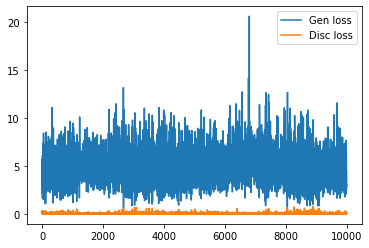

epoch: 60 	 step:0 	 loss: 5.393
epoch: 60 	 step:100 	 loss: 3.971
epoch: 60 	 step:200 	 loss: 3.721
epoch: 60 	 step:300 	 loss: 2.637
epoch: 60 	 step:400 	 loss: 9.324
epoch: 60 	 step:500 	 loss: 2.902
epoch: 60 	 step:600 	 loss: 4.013
epoch: 60 	 step:700 	 loss: 3.624
epoch: 60 	 step:800 	 loss: 4.41
epoch: 60 	 step:900 	 loss: 2.134
epoch: 60 	 step:1000 	 loss: 4.889
epoch: 60 	 step:1100 	 loss: 1.64
epoch: 60 	 step:1200 	 loss: 5.878
epoch: 60 	 step:1300 	 loss: 4.24
epoch: 60 	 step:1400 	 loss: 4.312
epoch: 60 	 step:1500 	 loss: 3.823
epoch: 60 	 step:1600 	 loss: 7.374
epoch: 60 	 step:1700 	 loss: 2.902
epoch: 60 	 step:1800 	 loss: 2.887


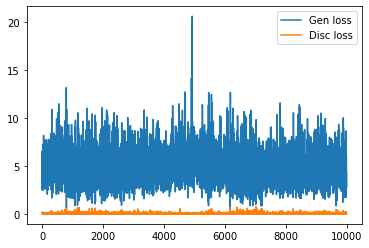

epoch: 61 	 step:0 	 loss: 5.598
epoch: 61 	 step:100 	 loss: 5.848
epoch: 61 	 step:200 	 loss: 5.349
epoch: 61 	 step:300 	 loss: 6.833
epoch: 61 	 step:400 	 loss: 6.298
epoch: 61 	 step:500 	 loss: 4.946
epoch: 61 	 step:600 	 loss: 7.523
epoch: 61 	 step:700 	 loss: 4.421
epoch: 61 	 step:800 	 loss: 3.513
epoch: 61 	 step:900 	 loss: 5.165
epoch: 61 	 step:1000 	 loss: 5.895
epoch: 61 	 step:1100 	 loss: 7.27
epoch: 61 	 step:1200 	 loss: 3.944
epoch: 61 	 step:1300 	 loss: 1.987
epoch: 61 	 step:1400 	 loss: 2.177
epoch: 61 	 step:1500 	 loss: 4.738
epoch: 61 	 step:1600 	 loss: 4.742
epoch: 61 	 step:1700 	 loss: 5.554
epoch: 61 	 step:1800 	 loss: 4.642


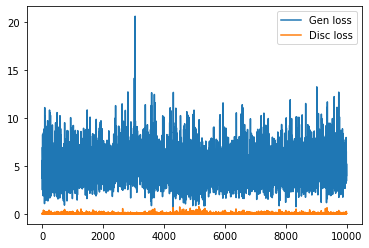

epoch: 62 	 step:0 	 loss: 6.96
epoch: 62 	 step:100 	 loss: 6.134
epoch: 62 	 step:200 	 loss: 4.93
epoch: 62 	 step:300 	 loss: 7.152
epoch: 62 	 step:400 	 loss: 2.81
epoch: 62 	 step:500 	 loss: 2.779
epoch: 62 	 step:600 	 loss: 6.571
epoch: 62 	 step:700 	 loss: 6.422
epoch: 62 	 step:800 	 loss: 3.693
epoch: 62 	 step:900 	 loss: 4.988
epoch: 62 	 step:1000 	 loss: 3.758
epoch: 62 	 step:1100 	 loss: 5.559
epoch: 62 	 step:1200 	 loss: 4.453
epoch: 62 	 step:1300 	 loss: 8.697
epoch: 62 	 step:1400 	 loss: 2.487
epoch: 62 	 step:1500 	 loss: 4.515
epoch: 62 	 step:1600 	 loss: 6.1
epoch: 62 	 step:1700 	 loss: 3.95
epoch: 62 	 step:1800 	 loss: 5.743


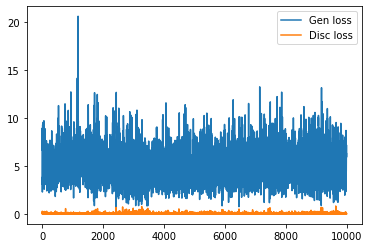

epoch: 63 	 step:0 	 loss: 4.342
epoch: 63 	 step:100 	 loss: 6.761
epoch: 63 	 step:200 	 loss: 3.582
epoch: 63 	 step:300 	 loss: 3.796
epoch: 63 	 step:400 	 loss: 4.097
epoch: 63 	 step:500 	 loss: 4.225
epoch: 63 	 step:600 	 loss: 8.149
epoch: 63 	 step:700 	 loss: 7.109
epoch: 63 	 step:800 	 loss: 5.295
epoch: 63 	 step:900 	 loss: 6.391
epoch: 63 	 step:1000 	 loss: 4.504
epoch: 63 	 step:1100 	 loss: 5.161
epoch: 63 	 step:1200 	 loss: 5.147
epoch: 63 	 step:1300 	 loss: 5.488
epoch: 63 	 step:1400 	 loss: 7.104
epoch: 63 	 step:1500 	 loss: 4.949
epoch: 63 	 step:1600 	 loss: 5.546
epoch: 63 	 step:1700 	 loss: 4.152
epoch: 63 	 step:1800 	 loss: 5.708


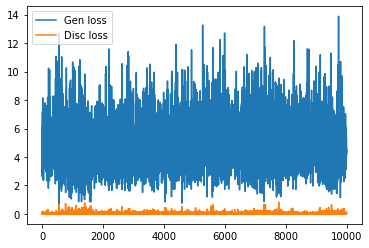

epoch: 64 	 step:0 	 loss: 4.886
epoch: 64 	 step:100 	 loss: 3.388
epoch: 64 	 step:200 	 loss: 5.424
epoch: 64 	 step:300 	 loss: 5.063
epoch: 64 	 step:400 	 loss: 2.625
epoch: 64 	 step:500 	 loss: 3.261
epoch: 64 	 step:600 	 loss: 4.286
epoch: 64 	 step:700 	 loss: 5.933
epoch: 64 	 step:800 	 loss: 4.028
epoch: 64 	 step:900 	 loss: 4.116
epoch: 64 	 step:1000 	 loss: 3.405
epoch: 64 	 step:1100 	 loss: 2.512
epoch: 64 	 step:1200 	 loss: 4.776
epoch: 64 	 step:1300 	 loss: 1.972
epoch: 64 	 step:1400 	 loss: 4.588
epoch: 64 	 step:1500 	 loss: 7.561
epoch: 64 	 step:1600 	 loss: 5.806
epoch: 64 	 step:1700 	 loss: 5.514
epoch: 64 	 step:1800 	 loss: 3.143


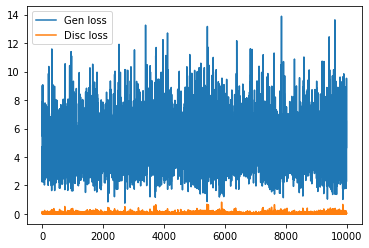

epoch: 65 	 step:0 	 loss: 4.318
epoch: 65 	 step:100 	 loss: 5.389
epoch: 65 	 step:200 	 loss: 3.34
epoch: 65 	 step:300 	 loss: 1.783
epoch: 65 	 step:400 	 loss: 6.968
epoch: 65 	 step:500 	 loss: 5.892
epoch: 65 	 step:600 	 loss: 3.189
epoch: 65 	 step:700 	 loss: 4.03
epoch: 65 	 step:800 	 loss: 4.481
epoch: 65 	 step:900 	 loss: 5.923
epoch: 65 	 step:1000 	 loss: 4.456
epoch: 65 	 step:1100 	 loss: 4.158
epoch: 65 	 step:1200 	 loss: 2.675
epoch: 65 	 step:1300 	 loss: 3.482
epoch: 65 	 step:1400 	 loss: 5.651
epoch: 65 	 step:1500 	 loss: 5.541
epoch: 65 	 step:1600 	 loss: 3.69
epoch: 65 	 step:1700 	 loss: 4.298
epoch: 65 	 step:1800 	 loss: 3.467


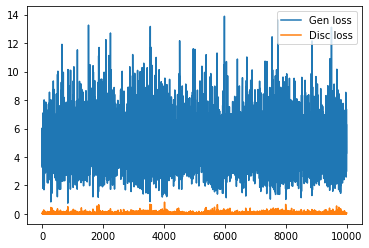

epoch: 66 	 step:0 	 loss: 3.467
epoch: 66 	 step:100 	 loss: 4.681
epoch: 66 	 step:200 	 loss: 8.913
epoch: 66 	 step:300 	 loss: 5.114
epoch: 66 	 step:400 	 loss: 6.051
epoch: 66 	 step:500 	 loss: 9.077
epoch: 66 	 step:600 	 loss: 4.064
epoch: 66 	 step:700 	 loss: 5.195
epoch: 66 	 step:800 	 loss: 4.258
epoch: 66 	 step:900 	 loss: 4.519
epoch: 66 	 step:1000 	 loss: 5.107
epoch: 66 	 step:1100 	 loss: 3.668
epoch: 66 	 step:1200 	 loss: 4.306
epoch: 66 	 step:1300 	 loss: 6.949
epoch: 66 	 step:1400 	 loss: 8.828
epoch: 66 	 step:1500 	 loss: 2.605
epoch: 66 	 step:1600 	 loss: 6.241
epoch: 66 	 step:1700 	 loss: 4.892
epoch: 66 	 step:1800 	 loss: 4.366


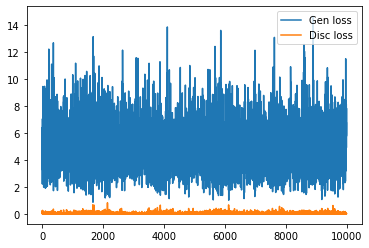

epoch: 67 	 step:0 	 loss: 5.77
epoch: 67 	 step:100 	 loss: 2.624
epoch: 67 	 step:200 	 loss: 10.15
epoch: 67 	 step:300 	 loss: 4.898
epoch: 67 	 step:400 	 loss: 5.281
epoch: 67 	 step:500 	 loss: 4.89
epoch: 67 	 step:600 	 loss: 4.096
epoch: 67 	 step:700 	 loss: 2.942
epoch: 67 	 step:800 	 loss: 5.25
epoch: 67 	 step:900 	 loss: 4.375
epoch: 67 	 step:1000 	 loss: 3.948
epoch: 67 	 step:1100 	 loss: 5.386
epoch: 67 	 step:1200 	 loss: 5.299
epoch: 67 	 step:1300 	 loss: 8.216
epoch: 67 	 step:1400 	 loss: 8.817
epoch: 67 	 step:1500 	 loss: 3.678
epoch: 67 	 step:1600 	 loss: 3.027
epoch: 67 	 step:1700 	 loss: 3.719
epoch: 67 	 step:1800 	 loss: 5.916


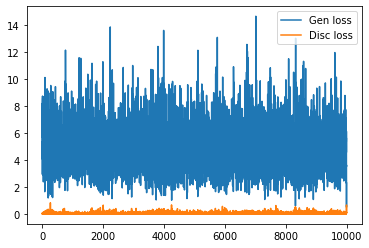

epoch: 68 	 step:0 	 loss: 10.08
epoch: 68 	 step:100 	 loss: 4.591
epoch: 68 	 step:200 	 loss: 5.204
epoch: 68 	 step:300 	 loss: 6.523
epoch: 68 	 step:400 	 loss: 2.942
epoch: 68 	 step:500 	 loss: 6.675
epoch: 68 	 step:600 	 loss: 4.198
epoch: 68 	 step:700 	 loss: 4.396
epoch: 68 	 step:800 	 loss: 6.49
epoch: 68 	 step:900 	 loss: 5.449
epoch: 68 	 step:1000 	 loss: 4.509
epoch: 68 	 step:1100 	 loss: 5.053
epoch: 68 	 step:1200 	 loss: 2.368
epoch: 68 	 step:1300 	 loss: 2.426
epoch: 68 	 step:1400 	 loss: 6.122
epoch: 68 	 step:1500 	 loss: 7.764
epoch: 68 	 step:1600 	 loss: 2.45
epoch: 68 	 step:1700 	 loss: 6.019
epoch: 68 	 step:1800 	 loss: 3.923


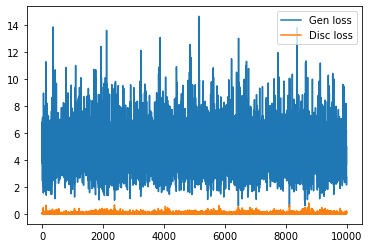

epoch: 69 	 step:0 	 loss: 5.301
epoch: 69 	 step:100 	 loss: 2.826
epoch: 69 	 step:200 	 loss: 5.298
epoch: 69 	 step:300 	 loss: 3.212
epoch: 69 	 step:400 	 loss: 6.95
epoch: 69 	 step:500 	 loss: 3.932
epoch: 69 	 step:600 	 loss: 5.414
epoch: 69 	 step:700 	 loss: 2.773
epoch: 69 	 step:800 	 loss: 6.423
epoch: 69 	 step:900 	 loss: 8.121
epoch: 69 	 step:1000 	 loss: 4.116
epoch: 69 	 step:1100 	 loss: 6.802
epoch: 69 	 step:1200 	 loss: 5.358
epoch: 69 	 step:1300 	 loss: 6.258
epoch: 69 	 step:1400 	 loss: 4.851
epoch: 69 	 step:1500 	 loss: 7.124
epoch: 69 	 step:1600 	 loss: 3.723
epoch: 69 	 step:1700 	 loss: 2.897
epoch: 69 	 step:1800 	 loss: 5.358


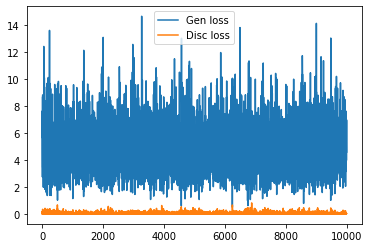

epoch: 70 	 step:0 	 loss: 3.643
epoch: 70 	 step:100 	 loss: 1.862
epoch: 70 	 step:200 	 loss: 6.438
epoch: 70 	 step:300 	 loss: 4.999
epoch: 70 	 step:400 	 loss: 4.12
epoch: 70 	 step:500 	 loss: 6.161
epoch: 70 	 step:600 	 loss: 4.201
epoch: 70 	 step:700 	 loss: 5.065
epoch: 70 	 step:800 	 loss: 4.89
epoch: 70 	 step:900 	 loss: 5.601
epoch: 70 	 step:1000 	 loss: 6.949
epoch: 70 	 step:1100 	 loss: 7.14
epoch: 70 	 step:1200 	 loss: 5.287
epoch: 70 	 step:1300 	 loss: 5.678
epoch: 70 	 step:1400 	 loss: 3.367
epoch: 70 	 step:1500 	 loss: 7.02
epoch: 70 	 step:1600 	 loss: 7.479
epoch: 70 	 step:1700 	 loss: 4.825
epoch: 70 	 step:1800 	 loss: 5.303


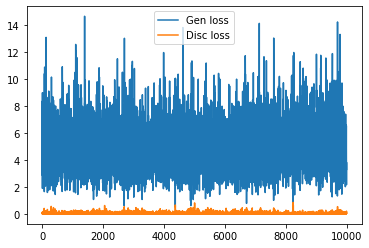

epoch: 71 	 step:0 	 loss: 4.646
epoch: 71 	 step:100 	 loss: 4.147
epoch: 71 	 step:200 	 loss: 7.231
epoch: 71 	 step:300 	 loss: 5.285
epoch: 71 	 step:400 	 loss: 4.017
epoch: 71 	 step:500 	 loss: 2.635
epoch: 71 	 step:600 	 loss: 4.398
epoch: 71 	 step:700 	 loss: 3.01
epoch: 71 	 step:800 	 loss: 5.246
epoch: 71 	 step:900 	 loss: 5.914
epoch: 71 	 step:1000 	 loss: 3.903
epoch: 71 	 step:1100 	 loss: 4.201
epoch: 71 	 step:1200 	 loss: 4.543
epoch: 71 	 step:1300 	 loss: 5.258
epoch: 71 	 step:1400 	 loss: 4.828
epoch: 71 	 step:1500 	 loss: 6.533
epoch: 71 	 step:1600 	 loss: 2.314
epoch: 71 	 step:1700 	 loss: 3.954
epoch: 71 	 step:1800 	 loss: 3.923


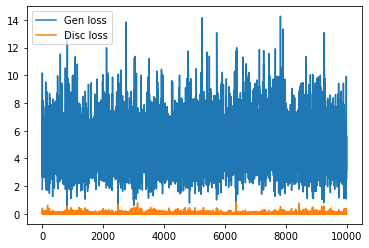

epoch: 72 	 step:0 	 loss: 4.897
epoch: 72 	 step:100 	 loss: 6.887
epoch: 72 	 step:200 	 loss: 5.869
epoch: 72 	 step:300 	 loss: 5.259
epoch: 72 	 step:400 	 loss: 3.787
epoch: 72 	 step:500 	 loss: 3.407
epoch: 72 	 step:600 	 loss: 1.383
epoch: 72 	 step:700 	 loss: 9.354
epoch: 72 	 step:800 	 loss: 5.065
epoch: 72 	 step:900 	 loss: 5.756
epoch: 72 	 step:1000 	 loss: 4.697
epoch: 72 	 step:1100 	 loss: 4.638
epoch: 72 	 step:1200 	 loss: 5.671
epoch: 72 	 step:1300 	 loss: 5.49
epoch: 72 	 step:1400 	 loss: 5.744
epoch: 72 	 step:1500 	 loss: 4.957
epoch: 72 	 step:1600 	 loss: 5.154
epoch: 72 	 step:1700 	 loss: 5.252
epoch: 72 	 step:1800 	 loss: 3.553


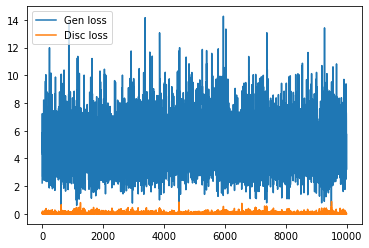

epoch: 73 	 step:0 	 loss: 4.673
epoch: 73 	 step:100 	 loss: 4.977
epoch: 73 	 step:200 	 loss: 7.151
epoch: 73 	 step:300 	 loss: 3.626
epoch: 73 	 step:400 	 loss: 6.902
epoch: 73 	 step:500 	 loss: 5.318
epoch: 73 	 step:600 	 loss: 4.65
epoch: 73 	 step:700 	 loss: 4.34
epoch: 73 	 step:800 	 loss: 3.563
epoch: 73 	 step:900 	 loss: 5.311
epoch: 73 	 step:1000 	 loss: 7.554
epoch: 73 	 step:1100 	 loss: 6.465
epoch: 73 	 step:1200 	 loss: 7.671
epoch: 73 	 step:1300 	 loss: 9.872
epoch: 73 	 step:1400 	 loss: 4.129
epoch: 73 	 step:1500 	 loss: 7.915
epoch: 73 	 step:1600 	 loss: 6.227
epoch: 73 	 step:1700 	 loss: 3.291
epoch: 73 	 step:1800 	 loss: 4.884


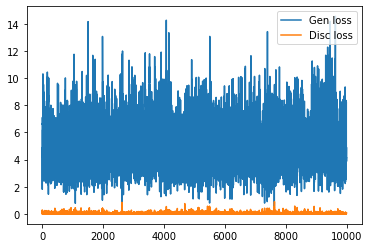

epoch: 74 	 step:0 	 loss: 8.475
epoch: 74 	 step:100 	 loss: 4.593
epoch: 74 	 step:200 	 loss: 4.649
epoch: 74 	 step:300 	 loss: 4.984
epoch: 74 	 step:400 	 loss: 6.317
epoch: 74 	 step:500 	 loss: 7.551
epoch: 74 	 step:600 	 loss: 3.211
epoch: 74 	 step:700 	 loss: 5.898
epoch: 74 	 step:800 	 loss: 4.407
epoch: 74 	 step:900 	 loss: 2.571
epoch: 74 	 step:1000 	 loss: 5.779
epoch: 74 	 step:1100 	 loss: 7.829
epoch: 74 	 step:1200 	 loss: 4.691
epoch: 74 	 step:1300 	 loss: 4.634
epoch: 74 	 step:1400 	 loss: 4.268
epoch: 74 	 step:1500 	 loss: 5.913
epoch: 74 	 step:1600 	 loss: 4.074
epoch: 74 	 step:1700 	 loss: 4.45
epoch: 74 	 step:1800 	 loss: 6.023


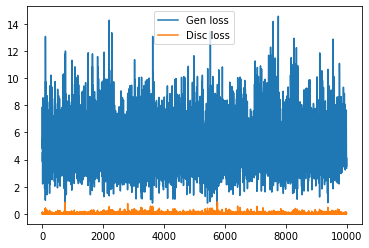

epoch: 75 	 step:0 	 loss: 5.945
epoch: 75 	 step:100 	 loss: 8.133
epoch: 75 	 step:200 	 loss: 5.106
epoch: 75 	 step:300 	 loss: 3.73
epoch: 75 	 step:400 	 loss: 8.235
epoch: 75 	 step:500 	 loss: 6.899
epoch: 75 	 step:600 	 loss: 6.228
epoch: 75 	 step:700 	 loss: 7.826
epoch: 75 	 step:800 	 loss: 2.463
epoch: 75 	 step:900 	 loss: 3.943
epoch: 75 	 step:1000 	 loss: 4.528
epoch: 75 	 step:1100 	 loss: 5.001
epoch: 75 	 step:1200 	 loss: 1.597
epoch: 75 	 step:1300 	 loss: 3.584
epoch: 75 	 step:1400 	 loss: 2.416
epoch: 75 	 step:1500 	 loss: 3.848
epoch: 75 	 step:1600 	 loss: 5.378
epoch: 75 	 step:1700 	 loss: 3.944
epoch: 75 	 step:1800 	 loss: 5.48


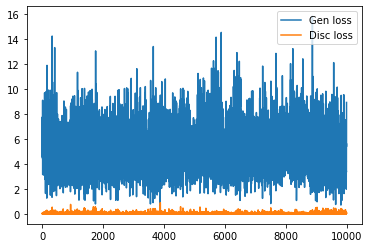

epoch: 76 	 step:0 	 loss: 4.636
epoch: 76 	 step:100 	 loss: 4.435
epoch: 76 	 step:200 	 loss: 3.726
epoch: 76 	 step:300 	 loss: 4.784
epoch: 76 	 step:400 	 loss: 5.136
epoch: 76 	 step:500 	 loss: 4.934
epoch: 76 	 step:600 	 loss: 4.031
epoch: 76 	 step:700 	 loss: 6.812
epoch: 76 	 step:800 	 loss: 2.702
epoch: 76 	 step:900 	 loss: 5.282
epoch: 76 	 step:1000 	 loss: 4.527
epoch: 76 	 step:1100 	 loss: 3.873
epoch: 76 	 step:1200 	 loss: 6.905
epoch: 76 	 step:1300 	 loss: 4.279
epoch: 76 	 step:1400 	 loss: 7.094
epoch: 76 	 step:1500 	 loss: 5.34
epoch: 76 	 step:1600 	 loss: 5.268
epoch: 76 	 step:1700 	 loss: 6.08
epoch: 76 	 step:1800 	 loss: 5.541


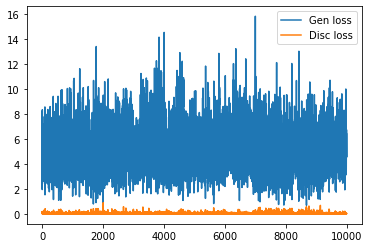

epoch: 77 	 step:0 	 loss: 4.701
epoch: 77 	 step:100 	 loss: 3.242
epoch: 77 	 step:200 	 loss: 3.563
epoch: 77 	 step:300 	 loss: 6.982
epoch: 77 	 step:400 	 loss: 6.293
epoch: 77 	 step:500 	 loss: 10.68
epoch: 77 	 step:600 	 loss: 3.972
epoch: 77 	 step:700 	 loss: 2.507
epoch: 77 	 step:800 	 loss: 2.331
epoch: 77 	 step:900 	 loss: 4.788
epoch: 77 	 step:1000 	 loss: 4.416
epoch: 77 	 step:1100 	 loss: 7.116
epoch: 77 	 step:1200 	 loss: 6.492
epoch: 77 	 step:1300 	 loss: 2.905
epoch: 77 	 step:1400 	 loss: 5.502
epoch: 77 	 step:1500 	 loss: 4.558
epoch: 77 	 step:1600 	 loss: 5.539
epoch: 77 	 step:1700 	 loss: 5.978
epoch: 77 	 step:1800 	 loss: 4.185


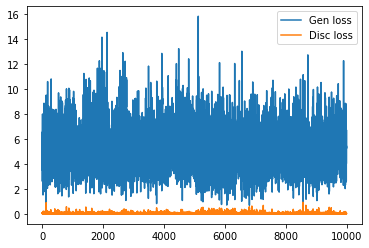

epoch: 78 	 step:0 	 loss: 4.43
epoch: 78 	 step:100 	 loss: 6.132
epoch: 78 	 step:200 	 loss: 6.521
epoch: 78 	 step:300 	 loss: 5.018
epoch: 78 	 step:400 	 loss: 1.903
epoch: 78 	 step:500 	 loss: 5.992
epoch: 78 	 step:600 	 loss: 5.434
epoch: 78 	 step:700 	 loss: 6.557
epoch: 78 	 step:800 	 loss: 2.766
epoch: 78 	 step:900 	 loss: 6.024
epoch: 78 	 step:1000 	 loss: 3.657
epoch: 78 	 step:1100 	 loss: 3.891
epoch: 78 	 step:1200 	 loss: 4.04
epoch: 78 	 step:1300 	 loss: 4.669
epoch: 78 	 step:1400 	 loss: 3.413
epoch: 78 	 step:1500 	 loss: 7.131
epoch: 78 	 step:1600 	 loss: 3.008
epoch: 78 	 step:1700 	 loss: 5.25
epoch: 78 	 step:1800 	 loss: 1.854


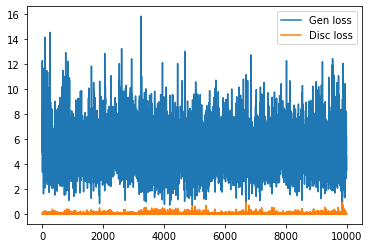

epoch: 79 	 step:0 	 loss: 3.439
epoch: 79 	 step:100 	 loss: 6.05
epoch: 79 	 step:200 	 loss: 4.201
epoch: 79 	 step:300 	 loss: 4.753
epoch: 79 	 step:400 	 loss: 4.898
epoch: 79 	 step:500 	 loss: 3.588
epoch: 79 	 step:600 	 loss: 4.572
epoch: 79 	 step:700 	 loss: 5.461
epoch: 79 	 step:800 	 loss: 6.936
epoch: 79 	 step:900 	 loss: 1.748
epoch: 79 	 step:1000 	 loss: 5.706
epoch: 79 	 step:1100 	 loss: 4.208
epoch: 79 	 step:1200 	 loss: 7.535
epoch: 79 	 step:1300 	 loss: 5.23
epoch: 79 	 step:1400 	 loss: 3.974
epoch: 79 	 step:1500 	 loss: 6.01
epoch: 79 	 step:1600 	 loss: 3.512
epoch: 79 	 step:1700 	 loss: 4.841
epoch: 79 	 step:1800 	 loss: 4.475


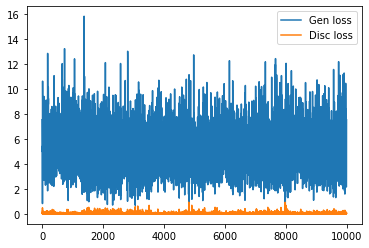

epoch: 80 	 step:0 	 loss: 6.497
epoch: 80 	 step:100 	 loss: 5.292
epoch: 80 	 step:200 	 loss: 4.77
epoch: 80 	 step:300 	 loss: 5.207
epoch: 80 	 step:400 	 loss: 4.776
epoch: 80 	 step:500 	 loss: 7.339
epoch: 80 	 step:600 	 loss: 7.428
epoch: 80 	 step:700 	 loss: 5.622
epoch: 80 	 step:800 	 loss: 4.685
epoch: 80 	 step:900 	 loss: 3.577
epoch: 80 	 step:1000 	 loss: 9.748
epoch: 80 	 step:1100 	 loss: 4.663
epoch: 80 	 step:1200 	 loss: 3.743
epoch: 80 	 step:1300 	 loss: 5.948
epoch: 80 	 step:1400 	 loss: 5.286
epoch: 80 	 step:1500 	 loss: 13.21
epoch: 80 	 step:1600 	 loss: 5.531
epoch: 80 	 step:1700 	 loss: 5.595
epoch: 80 	 step:1800 	 loss: 5.09


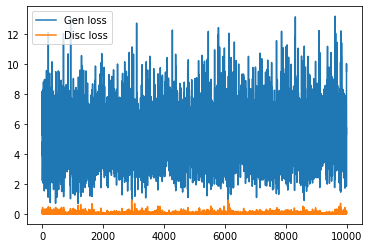

epoch: 81 	 step:0 	 loss: 7.428
epoch: 81 	 step:100 	 loss: 6.896
epoch: 81 	 step:200 	 loss: 3.745
epoch: 81 	 step:300 	 loss: 5.468
epoch: 81 	 step:400 	 loss: 5.315
epoch: 81 	 step:500 	 loss: 3.335
epoch: 81 	 step:600 	 loss: 3.814
epoch: 81 	 step:700 	 loss: 3.385
epoch: 81 	 step:800 	 loss: 4.234
epoch: 81 	 step:900 	 loss: 1.843
epoch: 81 	 step:1000 	 loss: 3.157
epoch: 81 	 step:1100 	 loss: 3.002
epoch: 81 	 step:1200 	 loss: 5.671
epoch: 81 	 step:1300 	 loss: 7.198
epoch: 81 	 step:1400 	 loss: 4.49
epoch: 81 	 step:1500 	 loss: 2.798
epoch: 81 	 step:1600 	 loss: 7.863
epoch: 81 	 step:1700 	 loss: 4.322
epoch: 81 	 step:1800 	 loss: 6.995


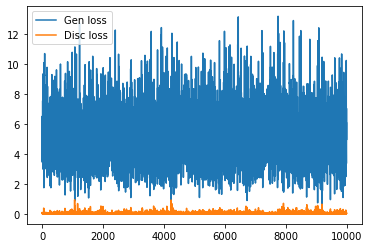

epoch: 82 	 step:0 	 loss: 4.643
epoch: 82 	 step:100 	 loss: 4.051
epoch: 82 	 step:200 	 loss: 4.234
epoch: 82 	 step:300 	 loss: 3.335
epoch: 82 	 step:400 	 loss: 6.719
epoch: 82 	 step:500 	 loss: 5.572
epoch: 82 	 step:600 	 loss: 5.736
epoch: 82 	 step:700 	 loss: 5.925
epoch: 82 	 step:800 	 loss: 3.453
epoch: 82 	 step:900 	 loss: 4.469
epoch: 82 	 step:1000 	 loss: 5.413
epoch: 82 	 step:1100 	 loss: 4.476
epoch: 82 	 step:1200 	 loss: 5.373
epoch: 82 	 step:1300 	 loss: 5.805
epoch: 82 	 step:1400 	 loss: 4.366
epoch: 82 	 step:1500 	 loss: 3.644
epoch: 82 	 step:1600 	 loss: 6.607
epoch: 82 	 step:1700 	 loss: 4.213
epoch: 82 	 step:1800 	 loss: 4.316


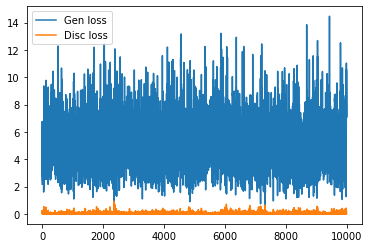

epoch: 83 	 step:0 	 loss: 7.435
epoch: 83 	 step:100 	 loss: 4.409
epoch: 83 	 step:200 	 loss: 10.79
epoch: 83 	 step:300 	 loss: 5.501
epoch: 83 	 step:400 	 loss: 8.96
epoch: 83 	 step:500 	 loss: 6.678
epoch: 83 	 step:600 	 loss: 5.81
epoch: 83 	 step:700 	 loss: 3.275
epoch: 83 	 step:800 	 loss: 2.919
epoch: 83 	 step:900 	 loss: 9.69
epoch: 83 	 step:1000 	 loss: 4.114
epoch: 83 	 step:1100 	 loss: 5.175
epoch: 83 	 step:1200 	 loss: 4.966
epoch: 83 	 step:1300 	 loss: 7.269
epoch: 83 	 step:1400 	 loss: 6.367
epoch: 83 	 step:1500 	 loss: 3.993
epoch: 83 	 step:1600 	 loss: 5.265
epoch: 83 	 step:1700 	 loss: 4.935
epoch: 83 	 step:1800 	 loss: 3.854


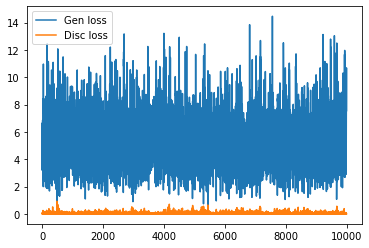

epoch: 84 	 step:0 	 loss: 8.167
epoch: 84 	 step:100 	 loss: 6.956
epoch: 84 	 step:200 	 loss: 2.951
epoch: 84 	 step:300 	 loss: 5.888
epoch: 84 	 step:400 	 loss: 3.798
epoch: 84 	 step:500 	 loss: 6.396
epoch: 84 	 step:600 	 loss: 7.155
epoch: 84 	 step:700 	 loss: 4.958
epoch: 84 	 step:800 	 loss: 5.625
epoch: 84 	 step:900 	 loss: 3.088
epoch: 84 	 step:1000 	 loss: 5.609
epoch: 84 	 step:1100 	 loss: 4.572
epoch: 84 	 step:1200 	 loss: 3.258
epoch: 84 	 step:1300 	 loss: 4.367
epoch: 84 	 step:1400 	 loss: 7.949
epoch: 84 	 step:1500 	 loss: 4.889
epoch: 84 	 step:1600 	 loss: 6.079
epoch: 84 	 step:1700 	 loss: 4.52
epoch: 84 	 step:1800 	 loss: 5.464


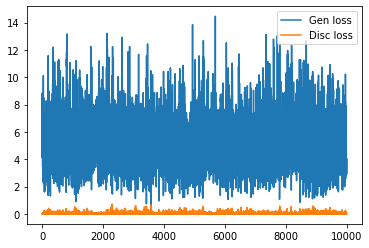

epoch: 85 	 step:0 	 loss: 6.087
epoch: 85 	 step:100 	 loss: 7.321
epoch: 85 	 step:200 	 loss: 3.886
epoch: 85 	 step:300 	 loss: 5.534
epoch: 85 	 step:400 	 loss: 5.285
epoch: 85 	 step:500 	 loss: 2.947
epoch: 85 	 step:600 	 loss: 2.233
epoch: 85 	 step:700 	 loss: 4.591
epoch: 85 	 step:800 	 loss: 10.95
epoch: 85 	 step:900 	 loss: 2.748
epoch: 85 	 step:1000 	 loss: 2.624
epoch: 85 	 step:1100 	 loss: 5.889
epoch: 85 	 step:1200 	 loss: 3.006
epoch: 85 	 step:1300 	 loss: 5.404
epoch: 85 	 step:1400 	 loss: 6.145
epoch: 85 	 step:1500 	 loss: 5.512
epoch: 85 	 step:1600 	 loss: 4.216
epoch: 85 	 step:1700 	 loss: 4.464
epoch: 85 	 step:1800 	 loss: 4.0


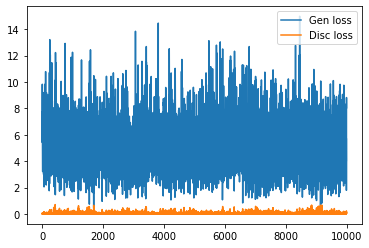

epoch: 86 	 step:0 	 loss: 7.248
epoch: 86 	 step:100 	 loss: 4.871
epoch: 86 	 step:200 	 loss: 4.124
epoch: 86 	 step:300 	 loss: 8.771
epoch: 86 	 step:400 	 loss: 7.418
epoch: 86 	 step:500 	 loss: 5.534
epoch: 86 	 step:600 	 loss: 7.931
epoch: 86 	 step:700 	 loss: 7.025
epoch: 86 	 step:800 	 loss: 3.535
epoch: 86 	 step:900 	 loss: 3.904
epoch: 86 	 step:1000 	 loss: 2.972
epoch: 86 	 step:1100 	 loss: 4.437
epoch: 86 	 step:1200 	 loss: 4.566
epoch: 86 	 step:1300 	 loss: 3.267
epoch: 86 	 step:1400 	 loss: 5.4
epoch: 86 	 step:1500 	 loss: 3.879
epoch: 86 	 step:1600 	 loss: 5.905
epoch: 86 	 step:1700 	 loss: 3.255
epoch: 86 	 step:1800 	 loss: 4.631


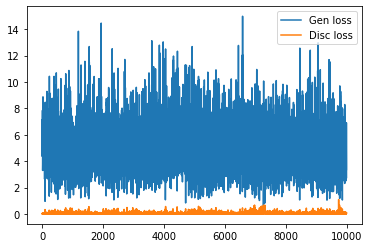

epoch: 87 	 step:0 	 loss: 5.97
epoch: 87 	 step:100 	 loss: 4.406
epoch: 87 	 step:200 	 loss: 3.238
epoch: 87 	 step:300 	 loss: 3.201
epoch: 87 	 step:400 	 loss: 6.655
epoch: 87 	 step:500 	 loss: 3.261
epoch: 87 	 step:600 	 loss: 6.232
epoch: 87 	 step:700 	 loss: 6.897
epoch: 87 	 step:800 	 loss: 3.175
epoch: 87 	 step:900 	 loss: 12.98
epoch: 87 	 step:1000 	 loss: 5.365
epoch: 87 	 step:1100 	 loss: 6.177
epoch: 87 	 step:1200 	 loss: 2.551
epoch: 87 	 step:1300 	 loss: 3.116
epoch: 87 	 step:1400 	 loss: 7.242
epoch: 87 	 step:1500 	 loss: 3.784
epoch: 87 	 step:1600 	 loss: 5.428
epoch: 87 	 step:1700 	 loss: 6.77
epoch: 87 	 step:1800 	 loss: 7.425


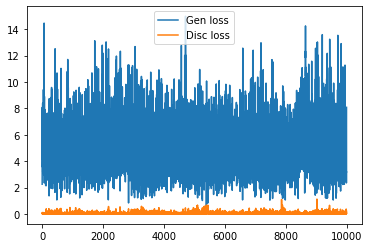

epoch: 88 	 step:0 	 loss: 7.126
epoch: 88 	 step:100 	 loss: 8.395
epoch: 88 	 step:200 	 loss: 3.961
epoch: 88 	 step:300 	 loss: 3.832
epoch: 88 	 step:400 	 loss: 6.46
epoch: 88 	 step:500 	 loss: 3.867
epoch: 88 	 step:600 	 loss: 4.252
epoch: 88 	 step:700 	 loss: 7.363
epoch: 88 	 step:800 	 loss: 5.215
epoch: 88 	 step:900 	 loss: 7.328
epoch: 88 	 step:1000 	 loss: 9.013
epoch: 88 	 step:1100 	 loss: 6.393
epoch: 88 	 step:1200 	 loss: 6.986
epoch: 88 	 step:1300 	 loss: 4.157
epoch: 88 	 step:1400 	 loss: 5.586
epoch: 88 	 step:1500 	 loss: 5.719
epoch: 88 	 step:1600 	 loss: 3.722
epoch: 88 	 step:1700 	 loss: 5.499
epoch: 88 	 step:1800 	 loss: 5.857


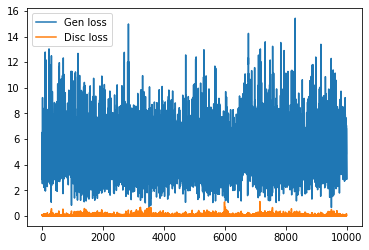

epoch: 89 	 step:0 	 loss: 1.959
epoch: 89 	 step:100 	 loss: 7.602
epoch: 89 	 step:200 	 loss: 4.856
epoch: 89 	 step:300 	 loss: 4.783
epoch: 89 	 step:400 	 loss: 7.907
epoch: 89 	 step:500 	 loss: 2.275
epoch: 89 	 step:600 	 loss: 6.114
epoch: 89 	 step:700 	 loss: 6.272
epoch: 89 	 step:800 	 loss: 6.333
epoch: 89 	 step:900 	 loss: 6.926
epoch: 89 	 step:1000 	 loss: 6.955
epoch: 89 	 step:1100 	 loss: 4.772
epoch: 89 	 step:1200 	 loss: 6.574
epoch: 89 	 step:1300 	 loss: 5.553
epoch: 89 	 step:1400 	 loss: 9.873
epoch: 89 	 step:1500 	 loss: 5.194
epoch: 89 	 step:1600 	 loss: 9.257
epoch: 89 	 step:1700 	 loss: 6.171
epoch: 89 	 step:1800 	 loss: 2.312


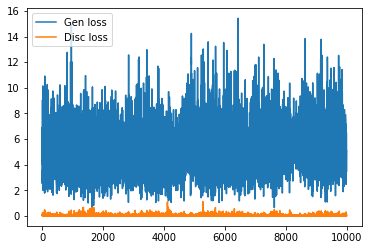

epoch: 90 	 step:0 	 loss: 6.159
epoch: 90 	 step:100 	 loss: 4.775
epoch: 90 	 step:200 	 loss: 9.346
epoch: 90 	 step:300 	 loss: 6.295
epoch: 90 	 step:400 	 loss: 7.795
epoch: 90 	 step:500 	 loss: 3.499
epoch: 90 	 step:600 	 loss: 6.15
epoch: 90 	 step:700 	 loss: 5.782
epoch: 90 	 step:800 	 loss: 3.158
epoch: 90 	 step:900 	 loss: 3.886
epoch: 90 	 step:1000 	 loss: 3.57
epoch: 90 	 step:1100 	 loss: 3.592
epoch: 90 	 step:1200 	 loss: 3.416
epoch: 90 	 step:1300 	 loss: 5.456
epoch: 90 	 step:1400 	 loss: 5.308
epoch: 90 	 step:1500 	 loss: 2.781
epoch: 90 	 step:1600 	 loss: 4.174
epoch: 90 	 step:1700 	 loss: 5.577
epoch: 90 	 step:1800 	 loss: 3.42


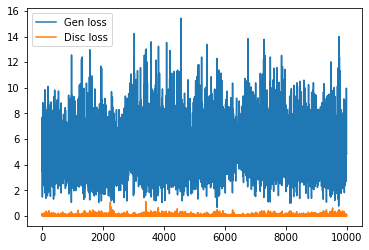

epoch: 91 	 step:0 	 loss: 3.388
epoch: 91 	 step:100 	 loss: 5.61
epoch: 91 	 step:200 	 loss: 8.31
epoch: 91 	 step:300 	 loss: 5.125
epoch: 91 	 step:400 	 loss: 8.269
epoch: 91 	 step:500 	 loss: 7.17
epoch: 91 	 step:600 	 loss: 6.233
epoch: 91 	 step:700 	 loss: 7.23
epoch: 91 	 step:800 	 loss: 5.268
epoch: 91 	 step:900 	 loss: 7.785
epoch: 91 	 step:1000 	 loss: 8.485
epoch: 91 	 step:1100 	 loss: 5.927
epoch: 91 	 step:1200 	 loss: 4.828
epoch: 91 	 step:1300 	 loss: 8.482
epoch: 91 	 step:1400 	 loss: 5.526
epoch: 91 	 step:1500 	 loss: 4.252
epoch: 91 	 step:1600 	 loss: 7.534
epoch: 91 	 step:1700 	 loss: 3.92
epoch: 91 	 step:1800 	 loss: 3.456


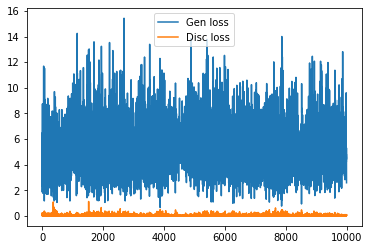

epoch: 92 	 step:0 	 loss: 3.497
epoch: 92 	 step:100 	 loss: 7.455
epoch: 92 	 step:200 	 loss: 7.14
epoch: 92 	 step:300 	 loss: 5.374
epoch: 92 	 step:400 	 loss: 6.302
epoch: 92 	 step:500 	 loss: 5.641
epoch: 92 	 step:600 	 loss: 2.751
epoch: 92 	 step:700 	 loss: 4.459
epoch: 92 	 step:800 	 loss: 8.86
epoch: 92 	 step:900 	 loss: 6.518
epoch: 92 	 step:1000 	 loss: 8.269
epoch: 92 	 step:1100 	 loss: 4.706
epoch: 92 	 step:1200 	 loss: 6.332
epoch: 92 	 step:1300 	 loss: 5.072
epoch: 92 	 step:1400 	 loss: 2.838
epoch: 92 	 step:1500 	 loss: 5.039
epoch: 92 	 step:1600 	 loss: 5.057
epoch: 92 	 step:1700 	 loss: 6.031
epoch: 92 	 step:1800 	 loss: 2.355


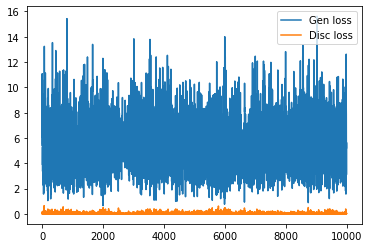

epoch: 93 	 step:0 	 loss: 6.89
epoch: 93 	 step:100 	 loss: 7.433
epoch: 93 	 step:200 	 loss: 5.433
epoch: 93 	 step:300 	 loss: 6.175
epoch: 93 	 step:400 	 loss: 6.363
epoch: 93 	 step:500 	 loss: 9.839
epoch: 93 	 step:600 	 loss: 6.574
epoch: 93 	 step:700 	 loss: 7.836
epoch: 93 	 step:800 	 loss: 5.454
epoch: 93 	 step:900 	 loss: 6.014
epoch: 93 	 step:1000 	 loss: 5.983
epoch: 93 	 step:1100 	 loss: 4.271
epoch: 93 	 step:1200 	 loss: 9.244
epoch: 93 	 step:1300 	 loss: 5.438
epoch: 93 	 step:1400 	 loss: 6.408
epoch: 93 	 step:1500 	 loss: 6.447
epoch: 93 	 step:1600 	 loss: 5.259
epoch: 93 	 step:1700 	 loss: 4.673
epoch: 93 	 step:1800 	 loss: 4.359


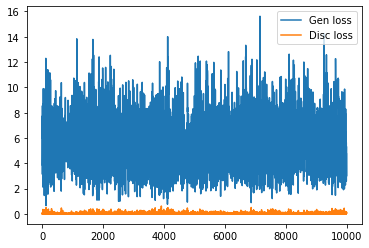

epoch: 94 	 step:0 	 loss: 3.522
epoch: 94 	 step:100 	 loss: 5.297
epoch: 94 	 step:200 	 loss: 4.164
epoch: 94 	 step:300 	 loss: 7.869
epoch: 94 	 step:400 	 loss: 5.944
epoch: 94 	 step:500 	 loss: 4.38
epoch: 94 	 step:600 	 loss: 1.76
epoch: 94 	 step:700 	 loss: 5.274
epoch: 94 	 step:800 	 loss: 5.525
epoch: 94 	 step:900 	 loss: 4.063
epoch: 94 	 step:1000 	 loss: 4.541
epoch: 94 	 step:1100 	 loss: 5.931
epoch: 94 	 step:1200 	 loss: 3.026
epoch: 94 	 step:1300 	 loss: 5.192
epoch: 94 	 step:1400 	 loss: 7.11
epoch: 94 	 step:1500 	 loss: 4.674
epoch: 94 	 step:1600 	 loss: 5.345
epoch: 94 	 step:1700 	 loss: 4.643
epoch: 94 	 step:1800 	 loss: 7.12


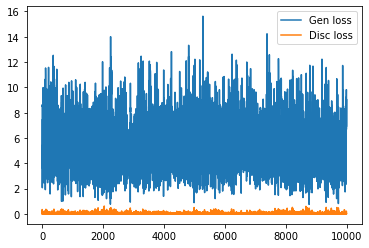

epoch: 95 	 step:0 	 loss: 7.593
epoch: 95 	 step:100 	 loss: 3.259
epoch: 95 	 step:200 	 loss: 5.629
epoch: 95 	 step:300 	 loss: 1.617
epoch: 95 	 step:400 	 loss: 5.549
epoch: 95 	 step:500 	 loss: 3.195
epoch: 95 	 step:600 	 loss: 6.85
epoch: 95 	 step:700 	 loss: 4.653
epoch: 95 	 step:800 	 loss: 3.964
epoch: 95 	 step:900 	 loss: 3.759
epoch: 95 	 step:1000 	 loss: 3.364
epoch: 95 	 step:1100 	 loss: 6.253
epoch: 95 	 step:1200 	 loss: 6.144
epoch: 95 	 step:1300 	 loss: 2.545
epoch: 95 	 step:1400 	 loss: 4.64
epoch: 95 	 step:1500 	 loss: 7.192
epoch: 95 	 step:1600 	 loss: 5.407
epoch: 95 	 step:1700 	 loss: 5.563
epoch: 95 	 step:1800 	 loss: 5.7


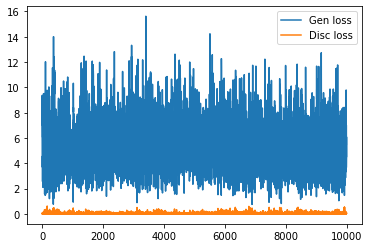

epoch: 96 	 step:0 	 loss: 6.912
epoch: 96 	 step:100 	 loss: 3.096
epoch: 96 	 step:200 	 loss: 4.052
epoch: 96 	 step:300 	 loss: 4.26
epoch: 96 	 step:400 	 loss: 6.146
epoch: 96 	 step:500 	 loss: 5.369
epoch: 96 	 step:600 	 loss: 6.139
epoch: 96 	 step:700 	 loss: 5.978
epoch: 96 	 step:800 	 loss: 6.836
epoch: 96 	 step:900 	 loss: 3.007
epoch: 96 	 step:1000 	 loss: 8.522
epoch: 96 	 step:1100 	 loss: 5.052
epoch: 96 	 step:1200 	 loss: 4.466
epoch: 96 	 step:1300 	 loss: 7.321
epoch: 96 	 step:1400 	 loss: 4.102
epoch: 96 	 step:1500 	 loss: 3.558
epoch: 96 	 step:1600 	 loss: 5.529
epoch: 96 	 step:1700 	 loss: 4.959
epoch: 96 	 step:1800 	 loss: 4.236


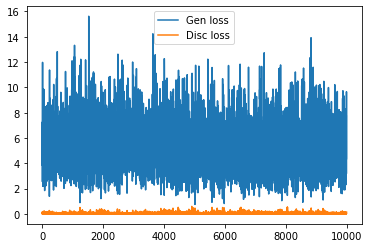

epoch: 97 	 step:0 	 loss: 5.903
epoch: 97 	 step:100 	 loss: 5.103
epoch: 97 	 step:200 	 loss: 9.264
epoch: 97 	 step:300 	 loss: 3.637
epoch: 97 	 step:400 	 loss: 4.578
epoch: 97 	 step:500 	 loss: 4.71
epoch: 97 	 step:600 	 loss: 6.03
epoch: 97 	 step:700 	 loss: 3.209
epoch: 97 	 step:800 	 loss: 5.657
epoch: 97 	 step:900 	 loss: 3.315
epoch: 97 	 step:1000 	 loss: 5.105
epoch: 97 	 step:1100 	 loss: 4.358
epoch: 97 	 step:1200 	 loss: 5.954
epoch: 97 	 step:1300 	 loss: 5.59
epoch: 97 	 step:1400 	 loss: 4.751
epoch: 97 	 step:1500 	 loss: 6.776
epoch: 97 	 step:1600 	 loss: 2.419
epoch: 97 	 step:1700 	 loss: 4.513
epoch: 97 	 step:1800 	 loss: 6.597


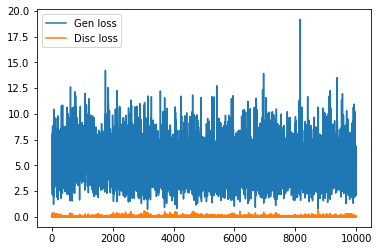

epoch: 98 	 step:0 	 loss: 4.536
epoch: 98 	 step:100 	 loss: 2.927
epoch: 98 	 step:200 	 loss: 6.505
epoch: 98 	 step:300 	 loss: 5.74
epoch: 98 	 step:400 	 loss: 3.351
epoch: 98 	 step:500 	 loss: 6.198
epoch: 98 	 step:600 	 loss: 4.507
epoch: 98 	 step:700 	 loss: 5.023
epoch: 98 	 step:800 	 loss: 2.463
epoch: 98 	 step:900 	 loss: 4.657
epoch: 98 	 step:1000 	 loss: 5.777
epoch: 98 	 step:1100 	 loss: 6.762
epoch: 98 	 step:1200 	 loss: 7.736
epoch: 98 	 step:1300 	 loss: 5.238
epoch: 98 	 step:1400 	 loss: 4.711
epoch: 98 	 step:1500 	 loss: 3.607
epoch: 98 	 step:1600 	 loss: 6.86
epoch: 98 	 step:1700 	 loss: 4.972
epoch: 98 	 step:1800 	 loss: 4.648


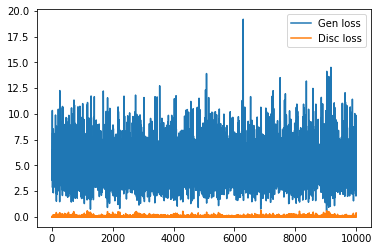

epoch: 99 	 step:0 	 loss: 8.76
epoch: 99 	 step:100 	 loss: 9.64
epoch: 99 	 step:200 	 loss: 2.921
epoch: 99 	 step:300 	 loss: 5.498
epoch: 99 	 step:400 	 loss: 4.933
epoch: 99 	 step:500 	 loss: 5.988
epoch: 99 	 step:600 	 loss: 6.718
epoch: 99 	 step:700 	 loss: 7.741
epoch: 99 	 step:800 	 loss: 6.678
epoch: 99 	 step:900 	 loss: 3.517
epoch: 99 	 step:1000 	 loss: 4.889
epoch: 99 	 step:1100 	 loss: 5.087
epoch: 99 	 step:1200 	 loss: 6.032
epoch: 99 	 step:1300 	 loss: 5.682
epoch: 99 	 step:1400 	 loss: 6.41
epoch: 99 	 step:1500 	 loss: 3.337
epoch: 99 	 step:1600 	 loss: 3.594
epoch: 99 	 step:1700 	 loss: 6.733
epoch: 99 	 step:1800 	 loss: 3.146


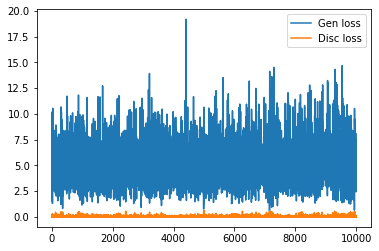

epoch: 100 	 step:0 	 loss: 4.046
epoch: 100 	 step:100 	 loss: 4.421
epoch: 100 	 step:200 	 loss: 3.542
epoch: 100 	 step:300 	 loss: 6.078
epoch: 100 	 step:400 	 loss: 6.9
epoch: 100 	 step:500 	 loss: 4.451
epoch: 100 	 step:600 	 loss: 2.55
epoch: 100 	 step:700 	 loss: 3.376
epoch: 100 	 step:800 	 loss: 4.774
epoch: 100 	 step:900 	 loss: 4.431
epoch: 100 	 step:1000 	 loss: 2.446
epoch: 100 	 step:1100 	 loss: 5.997
epoch: 100 	 step:1200 	 loss: 4.972
epoch: 100 	 step:1300 	 loss: 5.977
epoch: 100 	 step:1400 	 loss: 5.588
epoch: 100 	 step:1500 	 loss: 3.762
epoch: 100 	 step:1600 	 loss: 4.109
epoch: 100 	 step:1700 	 loss: 6.315
epoch: 100 	 step:1800 	 loss: 5.175


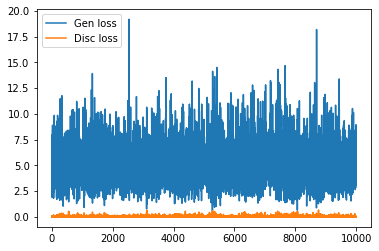

In [44]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/models/GAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name))
torch.save(disc_weights, "../cache/models/GAN_MNIST/ConvDiscriminator64MNIST_{}.sd".format(model_name))

In [52]:
### LOAD MODEL ####

model_name = "gan784"
z_size = 784

gen = models.FCNet(imsize=(1, 1, z_size), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/GAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/models/cGAN_MNIST/ConvDiscriminator64MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [53]:
def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        
        z = torch.randn(data.shape[0], 1, z_size).to(device)
        
        ouput = model(z)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [54]:
# Calculate test predictions #

test_predicted, test_original = test_generator(gen, device, dataloader['test'])
print(test_predicted.shape)

(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


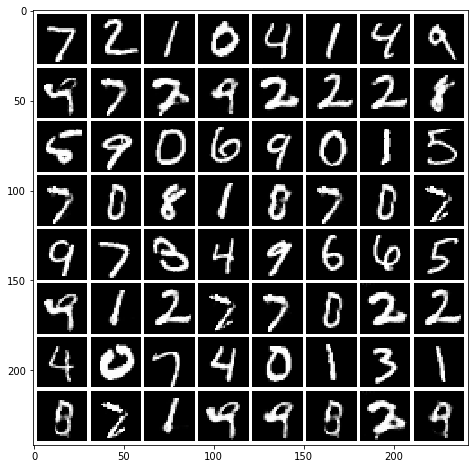

In [55]:
# Print test predictions 2 #
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/generative-prior/DPR/{}-raw.png".format(model_name))